# Pokemon Data Distributions Analysis

This notebook focuses on exploring the distributions and basic characteristics of the Pokemon dataset. All visualizations use a clean, presentation-ready color palette to highlight key insights about data types and important statistics.

## Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# prevent results from being clipped
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# set up consistent color palette across all notebooks
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
presentation_palette = sns.color_palette("Set2")  # 8 colors available

# load the pokemon dataset
df = pd.read_csv('Pokemon Database.csv')
print(f"dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"unique pokemon: {df['Pokemon Name'].nunique()}")

dataset loaded: 1382 rows, 45 columns
unique pokemon: 1025


## Data Overview and Cleaning

In [2]:
# dataset overview table
dataset_overview = pd.DataFrame({
    'metric': ['total rows', 'total columns', 'unique pokemon'],
    'value': [df.shape[0], df.shape[1], df['Pokemon Name'].nunique()]
})
dataset_overview

# column analysis table
column_info = []
for col in df.columns:
    column_info.append({
        'column': col,
        'data type': str(df[col].dtype),
        'missing values': df[col].isnull().sum()
    })
column_analysis = pd.DataFrame(column_info)
column_analysis

# select relevant columns - expanded to include physical characteristics, abilities, and ev stats
relevant_cols = [
    'Pokedex Number', 'Pokemon Name', 'Classification',
    'Primary Type', 'Secondary Type', 'Legendary Type',
    'Pokemon Height', 'Pokemon Weight',
    'Primary Ability', 'Secondary Ability', 'Hidden Ability',
    'Health Stat', 'Attack Stat', 'Defense Stat', 
    'Special Attack Stat', 'Special Defense Stat', 'Speed Stat', 'Base Stat Total',
    'Health EV', 'Attack EV', 'Defense EV', 
    'Special Attack EV', 'Special Defense EV', 'Speed EV', 'EV Yield Total',
    'Catch Rate', 'Base Happiness',
    'Male Ratio', 'Female Ratio',
    'Primary Egg Group', 'Secondary Egg Group'
]

df_clean = df[relevant_cols].copy()

# handle missing values
df_clean['Secondary Type'] = df_clean['Secondary Type'].fillna('None')
df_clean['Legendary Type'] = df_clean['Legendary Type'].fillna('Normal')
df_clean['Secondary Ability'] = df_clean['Secondary Ability'].fillna('None')
df_clean['Hidden Ability'] = df_clean['Hidden Ability'].fillna('None')
df_clean['Secondary Egg Group'] = df_clean['Secondary Egg Group'].fillna('None')

# fill numeric missing values with 0 or median where appropriate
df_clean['Pokemon Height'] = df_clean['Pokemon Height'].fillna(df_clean['Pokemon Height'].median())
df_clean['Pokemon Weight'] = df_clean['Pokemon Weight'].fillna(df_clean['Pokemon Weight'].median())
df_clean['Male Ratio'] = df_clean['Male Ratio'].fillna(-1)  # -1 indicates genderless
df_clean['Female Ratio'] = df_clean['Female Ratio'].fillna(-1)
df_clean['Base Happiness'] = df_clean['Base Happiness'].fillna(df_clean['Base Happiness'].median())

# remove duplicates by pokedex number, keeping the LAST entry (newest game stats)
df_clean = df_clean.sort_index().drop_duplicates(subset=['Pokedex Number'], keep='last')

# add derived features for analysis
df_clean['Is Legendary'] = (df_clean['Legendary Type'] != 'Normal').astype(int)
df_clean['Has Secondary Type'] = (df_clean['Secondary Type'] != 'None').astype(int)
df_clean['Has Secondary Ability'] = (df_clean['Secondary Ability'] != 'None').astype(int)
df_clean['Has Hidden Ability'] = (df_clean['Hidden Ability'] != 'None').astype(int)

# calculate additional derived features
df_clean['BMI'] = df_clean['Pokemon Weight'] / (df_clean['Pokemon Height'] ** 2)  # weight/height^2
df_clean['Physical Offense'] = df_clean['Attack Stat'] + df_clean['Speed Stat']
df_clean['Physical Defense'] = df_clean['Defense Stat'] + df_clean['Health Stat']
df_clean['Special Offense'] = df_clean['Special Attack Stat'] + df_clean['Speed Stat']
df_clean['Special Defense Total'] = df_clean['Special Defense Stat'] + df_clean['Health Stat']
df_clean['Offensive Total'] = df_clean['Attack Stat'] + df_clean['Special Attack Stat']
df_clean['Defensive Total'] = df_clean['Defense Stat'] + df_clean['Special Defense Stat']
df_clean['Stat Variance'] = df_clean[['Health Stat', 'Attack Stat', 'Defense Stat', 
                                        'Special Attack Stat', 'Special Defense Stat', 'Speed Stat']].var(axis=1)

print(f"cleaned dataset: {df_clean.shape[0]} pokemon, {df_clean.shape[1]} features")
print(f"legendary pokemon: {df_clean['Is Legendary'].sum()}")
print(f"pokemon with secondary types: {df_clean['Has Secondary Type'].sum()}")
print(f"pokemon with secondary abilities: {df_clean['Has Secondary Ability'].sum()}")
print(f"pokemon with hidden abilities: {df_clean['Has Hidden Ability'].sum()}")

# display feature categories
print("\nfeature categories:")
print(f"• identification: pokedex number, name, classification")
print(f"• types: primary type, secondary type, legendary type")
print(f"• physical: height, weight, bmi")
print(f"• abilities: primary, secondary, hidden")
print(f"• base stats: hp, atk, def, sp.atk, sp.def, speed, total")
print(f"• ev yields: hp, atk, def, sp.atk, sp.def, speed, total")
print(f"• game mechanics: catch rate, base happiness")
print(f"• breeding: male/female ratios, egg groups")
print(f"• derived features: stat variance, offensive/defensive totals, etc.")

# save the cleaned dataset for use in other notebooks
df_clean.to_csv('pokemon_cleaned.csv', index=False)
print("\ncleaned dataset saved as 'pokemon_cleaned.csv'")


cleaned dataset: 1025 pokemon, 43 features
legendary pokemon: 103
pokemon with secondary types: 560
pokemon with secondary abilities: 502
pokemon with hidden abilities: 804

feature categories:
• identification: pokedex number, name, classification
• types: primary type, secondary type, legendary type
• physical: height, weight, bmi
• abilities: primary, secondary, hidden
• base stats: hp, atk, def, sp.atk, sp.def, speed, total
• ev yields: hp, atk, def, sp.atk, sp.def, speed, total
• game mechanics: catch rate, base happiness
• breeding: male/female ratios, egg groups
• derived features: stat variance, offensive/defensive totals, etc.

cleaned dataset saved as 'pokemon_cleaned.csv'


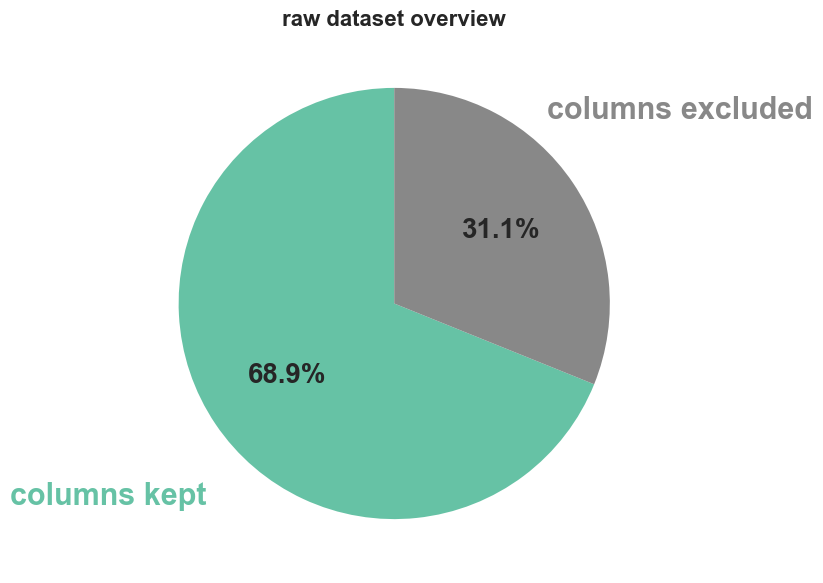

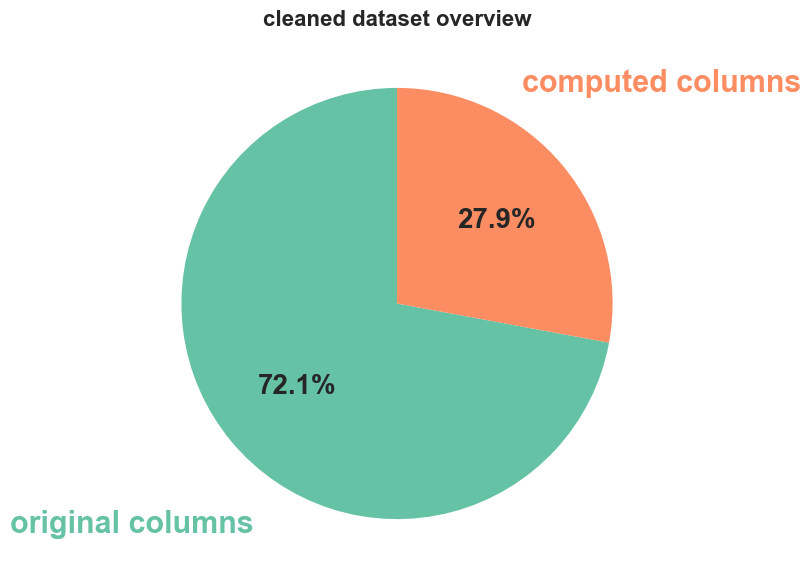

In [3]:
# --- GENERAL DATA OVERVIEW CHARTS ---
# Pie chart: number of columns in raw dataset
raw_col_count = len(df.columns)
raw_col_labels = ['columns kept', 'columns excluded']
raw_col_sizes = [len(relevant_cols), raw_col_count - len(relevant_cols)]
# use Set2[0] for kept, medium gray for excluded
#888888 is a medium gray
raw_col_colors = [presentation_palette[0], '#888888']
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(
    raw_col_sizes, labels=None, autopct='%1.1f%%', colors=raw_col_colors, startangle=90, textprops={'fontsize': 18}
    )
# set pie labels as colored text matching slice, moved out, larger font
for i, (wedge, label) in enumerate(zip(wedges, raw_col_labels)):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    x = np.cos(np.deg2rad(ang)) * 1.6
    y = np.sin(np.deg2rad(ang)) * 1.6
    ax.text(x, y, label, ha='center', va='center', fontsize=22, fontweight='bold', color=raw_col_colors[i])
for autotext in autotexts:
    autotext.set_fontsize(20)
    autotext.set_fontweight('bold')
ax.set_title('raw dataset overview', fontsize=16, fontweight='bold')
plt.savefig('figures/distribution/raw_columns_pie.png', dpi=800, bbox_inches='tight')
plt.show()

# Pie chart: number of columns in cleaned dataset
clean_col_count = len(df_clean.columns)
clean_col_labels = ['original columns', 'computed columns']
clean_col_sizes = [len(relevant_cols), len(df_clean.columns) - len(relevant_cols)]
clean_col_colors = [presentation_palette[0], presentation_palette[1]]
fig, ax = plt.subplots(figsize=(7, 7))
wedges, texts, autotexts = ax.pie(
    clean_col_sizes, labels=None, autopct='%1.1f%%', colors=clean_col_colors, startangle=90, textprops={'fontsize': 18}
    )
for i, (wedge, label) in enumerate(zip(wedges, clean_col_labels)):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    x = np.cos(np.deg2rad(ang)) * 1.6
    y = np.sin(np.deg2rad(ang)) * 1.6
    ax.text(x, y, label, ha='center', va='center', fontsize=22, fontweight='bold', color=clean_col_colors[i])
for autotext in autotexts:
    autotext.set_fontsize(20)
    autotext.set_fontweight('bold')
ax.set_title('cleaned dataset overview', fontsize=16, fontweight='bold')
plt.savefig('figures/distribution/cleaned_columns_pie.png', dpi=800, bbox_inches='tight')
plt.show()

In [4]:
# show what columns were excluded and what columns were added
original_cols = set(df.columns)
kept_cols = set(relevant_cols)
excluded_cols = sorted(original_cols - kept_cols)

# newly computed columns
computed_cols = [
    'Is Legendary', 'Has Secondary Type', 'Has Secondary Ability', 'Has Hidden Ability',
    'BMI', 'Physical Offense', 'Physical Defense', 'Special Offense', 
    'Special Defense Total', 'Offensive Total', 'Defensive Total', 'Stat Variance'
]

print("columns excluded from original dataset:")
for col in excluded_cols:
    print(f"  • {col}")
print(f"\ntotal excluded: {len(excluded_cols)} columns")

print("\nnewly computed columns added:")
for col in computed_cols:
    print(f"  • {col}")
print(f"\ntotal computed: {len(computed_cols)} columns")

print(f"\noriginal dataset: {len(original_cols)} columns")
print(f"kept from original: {len(kept_cols)} columns")
print(f"final dataset: {len(kept_cols) + len(computed_cols)} columns")

columns excluded from original dataset:
  • Alternate Form Name
  • Egg Cycle Count
  • Evolution Details
  • Experience Growth
  • Experience Growth Total
  • Game(s) of Origin
  • Hidden Ability Description
  • Original Pokemon ID
  • Pokemon Id
  • Pre-Evolution Pokemon Id
  • Primary Ability Description
  • Secondary Ability Description
  • Special Event Ability
  • Special Event Ability Description

total excluded: 14 columns

newly computed columns added:
  • Is Legendary
  • Has Secondary Type
  • Has Secondary Ability
  • Has Hidden Ability
  • BMI
  • Physical Offense
  • Physical Defense
  • Special Offense
  • Special Defense Total
  • Offensive Total
  • Defensive Total
  • Stat Variance

total computed: 12 columns

original dataset: 45 columns
kept from original: 31 columns
final dataset: 43 columns


## Type Distributions

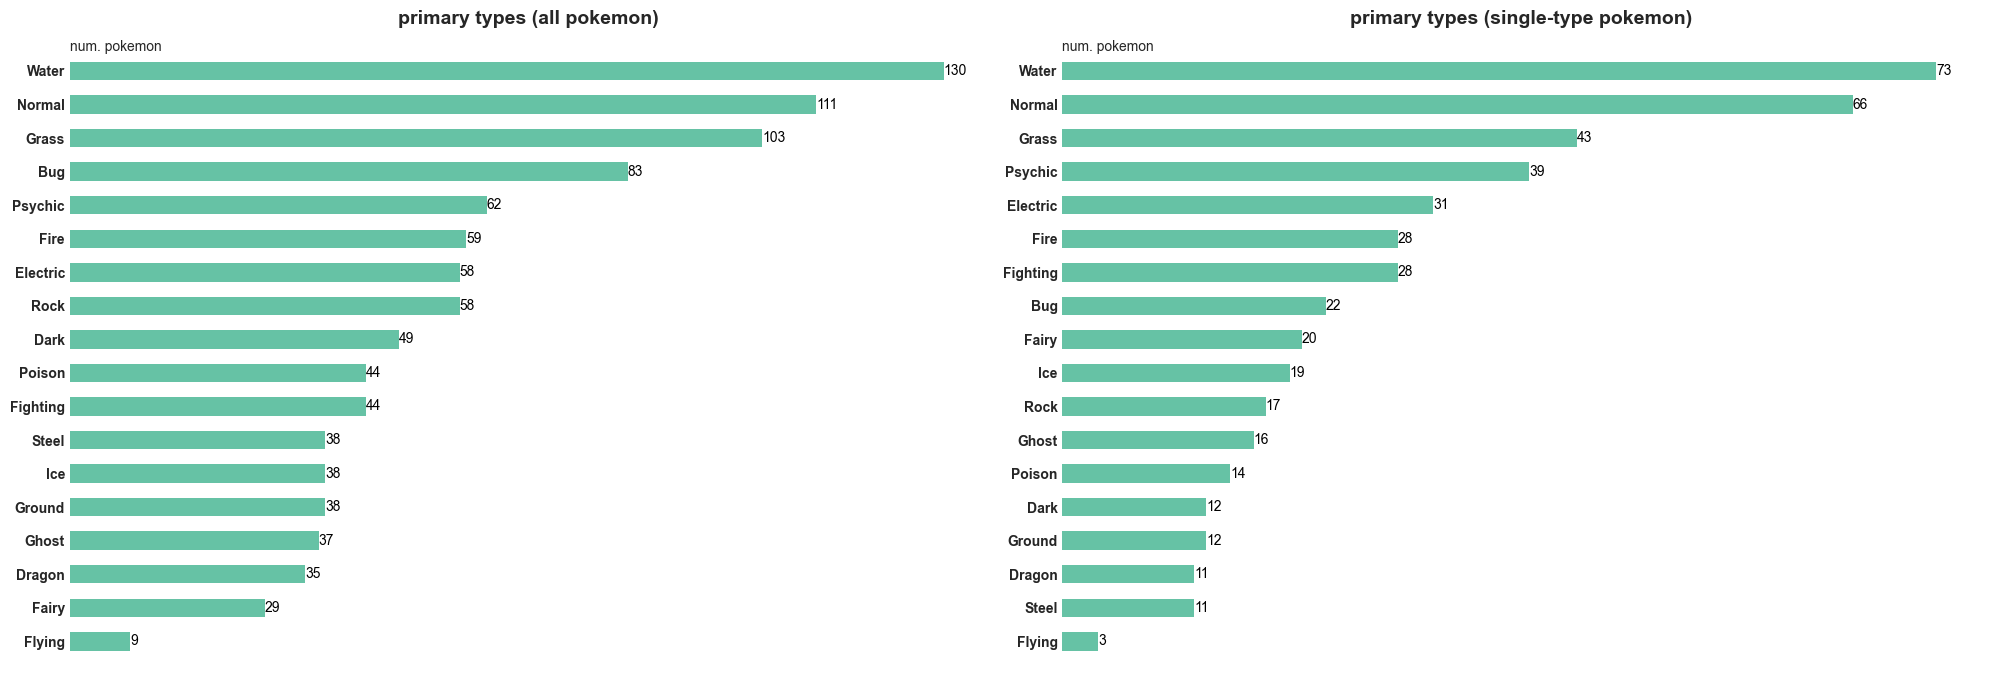

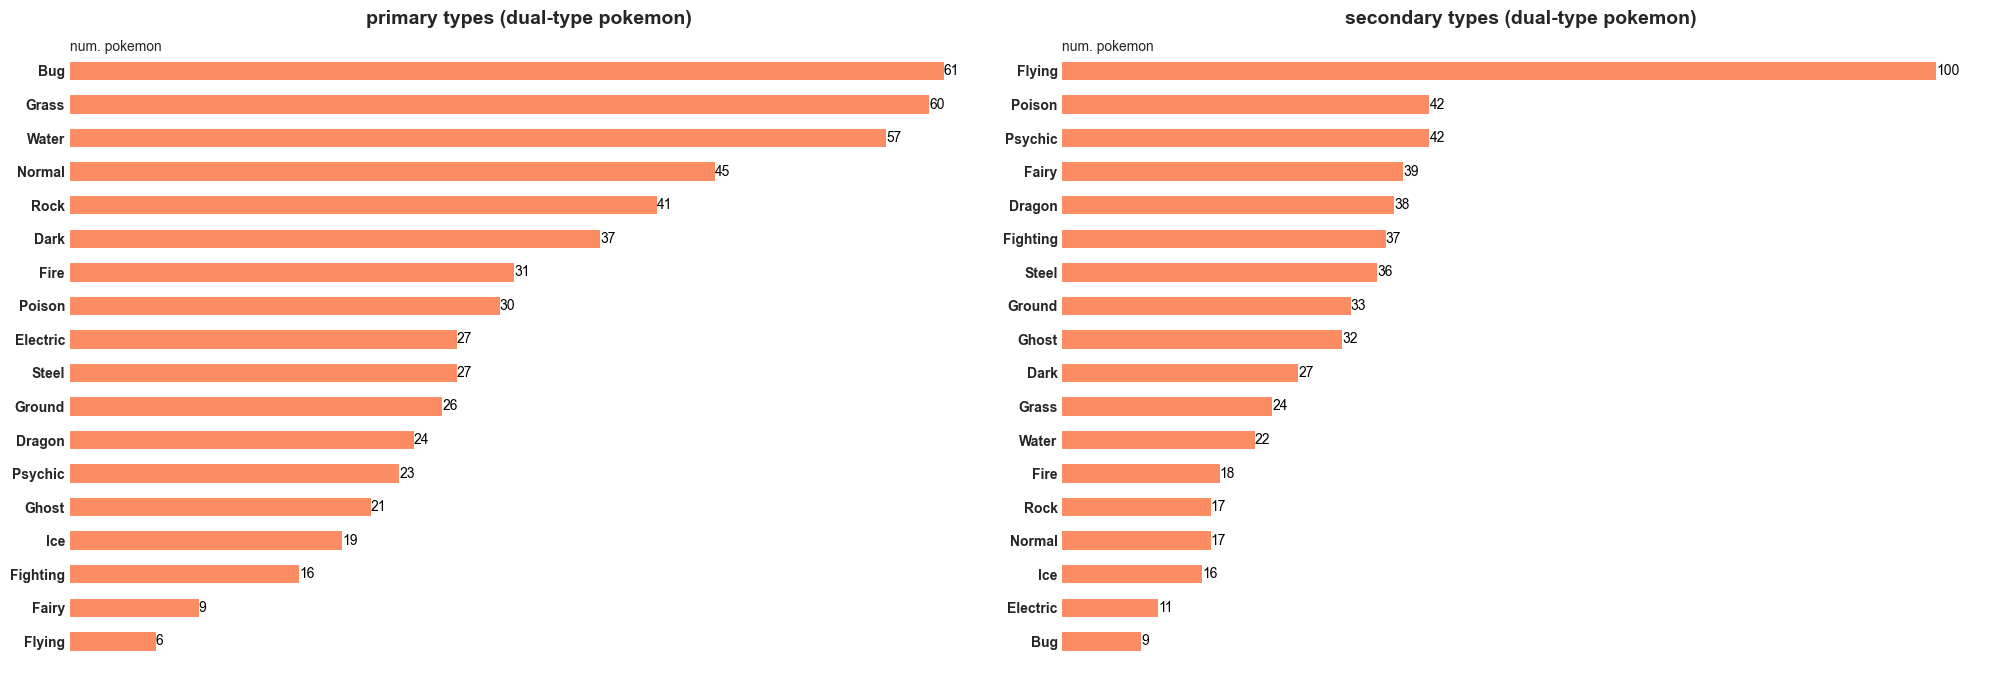

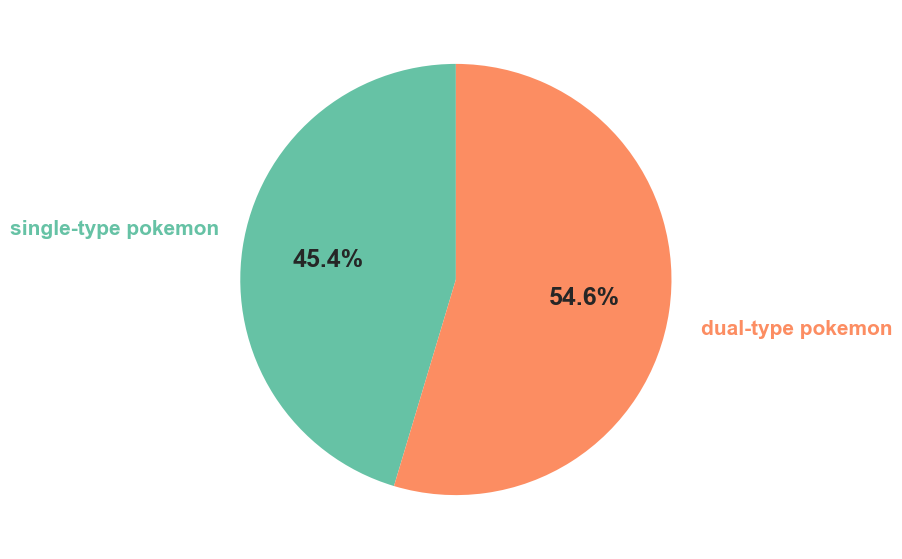

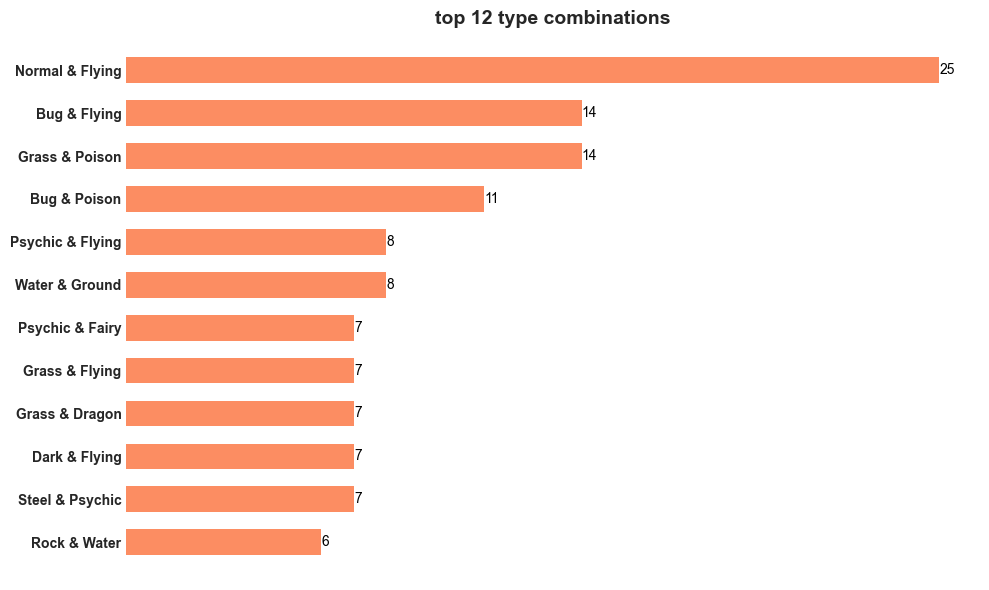

In [5]:
# --- TYPE DISTRIBUTION CHARTS ---
# define strip_quotes utility if missing
def strip_quotes(series):
    return series.str.replace('"', '').str.replace("'", '') if hasattr(series, 'str') else series

# create single_type and dual_type DataFrames
single_type = df_clean[df_clean['Has Secondary Type'] == 0]
dual_type = df_clean[df_clean['Has Secondary Type'] == 1]

# remove quotes from type columns before saving figures
df_clean['Primary Type'] = strip_quotes(df_clean['Primary Type'])
df_clean['Secondary Type'] = strip_quotes(df_clean['Secondary Type'])
single_type['Primary Type'] = strip_quotes(single_type['Primary Type'])
dual_type['Primary Type'] = strip_quotes(dual_type['Primary Type'])
dual_type['Secondary Type'] = strip_quotes(dual_type['Secondary Type'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
# full primary type distribution (all pokemon)
all_type_counts = df_clean['Primary Type'].value_counts(ascending=False)
bars1 = ax1.barh(all_type_counts.index[::-1], all_type_counts.values[::-1], color=presentation_palette[0], edgecolor='none', linewidth=0, height=0.55)
ax1.set_title('primary types (all pokemon)', fontsize=14, fontweight='bold')
ax1.axes.get_xaxis().set_visible(False)
ax1.grid(False)
ax1.set_frame_on(False)
for bar in bars1:
    bar.set_edgecolor('none')
    bar.set_linewidth(0)
for label in ax1.get_yticklabels():
    label.set_fontweight('bold')
ax1.text(0, len(all_type_counts)-0.5, 'num. pokemon', fontsize=10, fontweight='normal', ha='left', va='bottom')
for bar, count in zip(bars1, all_type_counts.values[::-1]):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{count}', ha='left', va='center', fontsize=10, color='black')
# single-type primary distribution
single_primary = single_type['Primary Type'].value_counts(ascending=False)
bars2 = ax2.barh(single_primary.index[::-1], single_primary.values[::-1], color=presentation_palette[0], edgecolor='none', linewidth=0, height=0.55)
ax2.set_title('primary types (single-type pokemon)', fontsize=14, fontweight='bold')
ax2.axes.get_xaxis().set_visible(False)
ax2.grid(False)
ax2.set_frame_on(False)
for bar in bars2:
    bar.set_edgecolor('none')
    bar.set_linewidth(0)
for label in ax2.get_yticklabels():
    label.set_fontweight('bold')
ax2.text(0, len(single_primary)-0.5, 'num. pokemon', fontsize=10, fontweight='normal', ha='left', va='bottom')
for bar, count in zip(bars2, single_primary.values[::-1]):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{count}', ha='left', va='center', fontsize=10, color='black')
plt.tight_layout()
plt.savefig('figures/distribution/primary_type_all_and_single.png', dpi=800, bbox_inches='tight')
plt.show()

# Group 2: Dual-type primary distribution and secondary type distribution (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
# dual-type primary distribution
dual_primary = dual_type['Primary Type'].value_counts(ascending=False)
bars1 = ax1.barh(dual_primary.index[::-1], dual_primary.values[::-1], color=presentation_palette[1], edgecolor='none', linewidth=0, height=0.55)
ax1.set_title('primary types (dual-type pokemon)', fontsize=14, fontweight='bold')
ax1.axes.get_xaxis().set_visible(False)
ax1.grid(False)
ax1.set_frame_on(False)
for bar in bars1:
    bar.set_edgecolor('none')
    bar.set_linewidth(0)
for label in ax1.get_yticklabels():
    label.set_fontweight('bold')
ax1.text(0, len(dual_primary)-0.5, 'num. pokemon', fontsize=10, fontweight='normal', ha='left', va='bottom')
for bar, count in zip(bars1, dual_primary.values[::-1]):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{count}', ha='left', va='center', fontsize=10, color='black')
# secondary type distribution (dual-type only)
secondary_counts = dual_type['Secondary Type'].value_counts(ascending=False)
bars2 = ax2.barh(secondary_counts.index[::-1], secondary_counts.values[::-1], color=presentation_palette[1], edgecolor='none', linewidth=0, height=0.55)
ax2.set_title('secondary types (dual-type pokemon)', fontsize=14, fontweight='bold')
ax2.axes.get_xaxis().set_visible(False)
ax2.grid(False)
ax2.set_frame_on(False)
for bar in bars2:
    bar.set_edgecolor('none')
    bar.set_linewidth(0)
for label in ax2.get_yticklabels():
    label.set_fontweight('bold')
ax2.text(0, len(secondary_counts)-0.5, 'num. pokemon', fontsize=10, fontweight='normal', ha='left', va='bottom')
for bar, count in zip(bars2, secondary_counts.values[::-1]):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{count}', ha='left', va='center', fontsize=10, color='black')
plt.tight_layout()
plt.savefig('figures/distribution/primary_and_secondary_dual_type.png', dpi=800, bbox_inches='tight')
plt.show()

# --- INDIVIDUAL CHARTS: PIE AND TOP COMBOS ---
# Pie chart: single-type vs dual-type pokemon
fig, ax = plt.subplots(figsize=(7, 7))
single_count = len(single_type)
dual_count = len(dual_type)
pie_labels = ['single-type pokemon', 'dual-type pokemon']
pie_sizes = [single_count, dual_count]
pie_colors = [presentation_palette[0], presentation_palette[1]]
wedges, texts, autotexts = ax.pie(
    pie_sizes,
    labels=None,
    autopct='%1.1f%%',
    colors=pie_colors,
    startangle=90,
    textprops={'fontsize': 16}
    )
# set pie labels as colored text matching slice, moved even further out
for i, (wedge, label) in enumerate(zip(wedges, pie_labels)):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    x = np.cos(np.deg2rad(ang)) * 1.6  # move labels further out
    y = np.sin(np.deg2rad(ang)) * 1.6
    ax.text(x, y, label, ha='center', va='center', fontsize=15,
            fontweight='bold', color=pie_colors[i])
# make percentage labels larger
for autotext in autotexts:
    autotext.set_fontsize(18)
    autotext.set_fontweight('bold')
ax.set_title(None)
plt.savefig('figures/distribution/single_vs_dual_pie.png',
            dpi=800, bbox_inches='tight')
plt.show()

# Top type combinations (dual-type)
top_n = 12
top_combos = dual_type.groupby(['Primary Type', 'Secondary Type']).size(
    ).sort_values(ascending=False).head(top_n)
top_combos_df = top_combos.reset_index(name='count')
top_combos_df['Primary Type'] = strip_quotes(top_combos_df['Primary Type'])
top_combos_df['Secondary Type'] = strip_quotes(top_combos_df['Secondary Type'])
fig, ax = plt.subplots(figsize=(10, 6))
combo_labels = [f"{row['Primary Type']} & {row['Secondary Type']}" for _, row in top_combos_df.iterrows()]
bars = ax.barh(combo_labels[::-1], top_combos_df['count'][::-1],
               color=presentation_palette[1], edgecolor=None, height=0.6)
for bar in bars:
    bar.set_edgecolor('none')  # ensure outline is removed
ax.set_title(f"top {top_n} type combinations", fontsize=14, fontweight='bold')
ax.set_xlabel('num. pokemon')
ax.set_ylabel('')
ax.grid(False)
ax.axes.get_xaxis().set_visible(False)
ax.set_frame_on(False)  # remove chart outline
for bar, count in zip(bars, top_combos_df['count'][::-1]):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
            f'{count}', ha='left', va='center', fontsize=10, color='black')
for label in ax.get_yticklabels():
    label.set_fontweight('bold')
plt.tight_layout()
plt.savefig('figures/distribution/top_type_combos.png',
            dpi=800, bbox_inches='tight')
plt.show()

## Base Stat Distributions

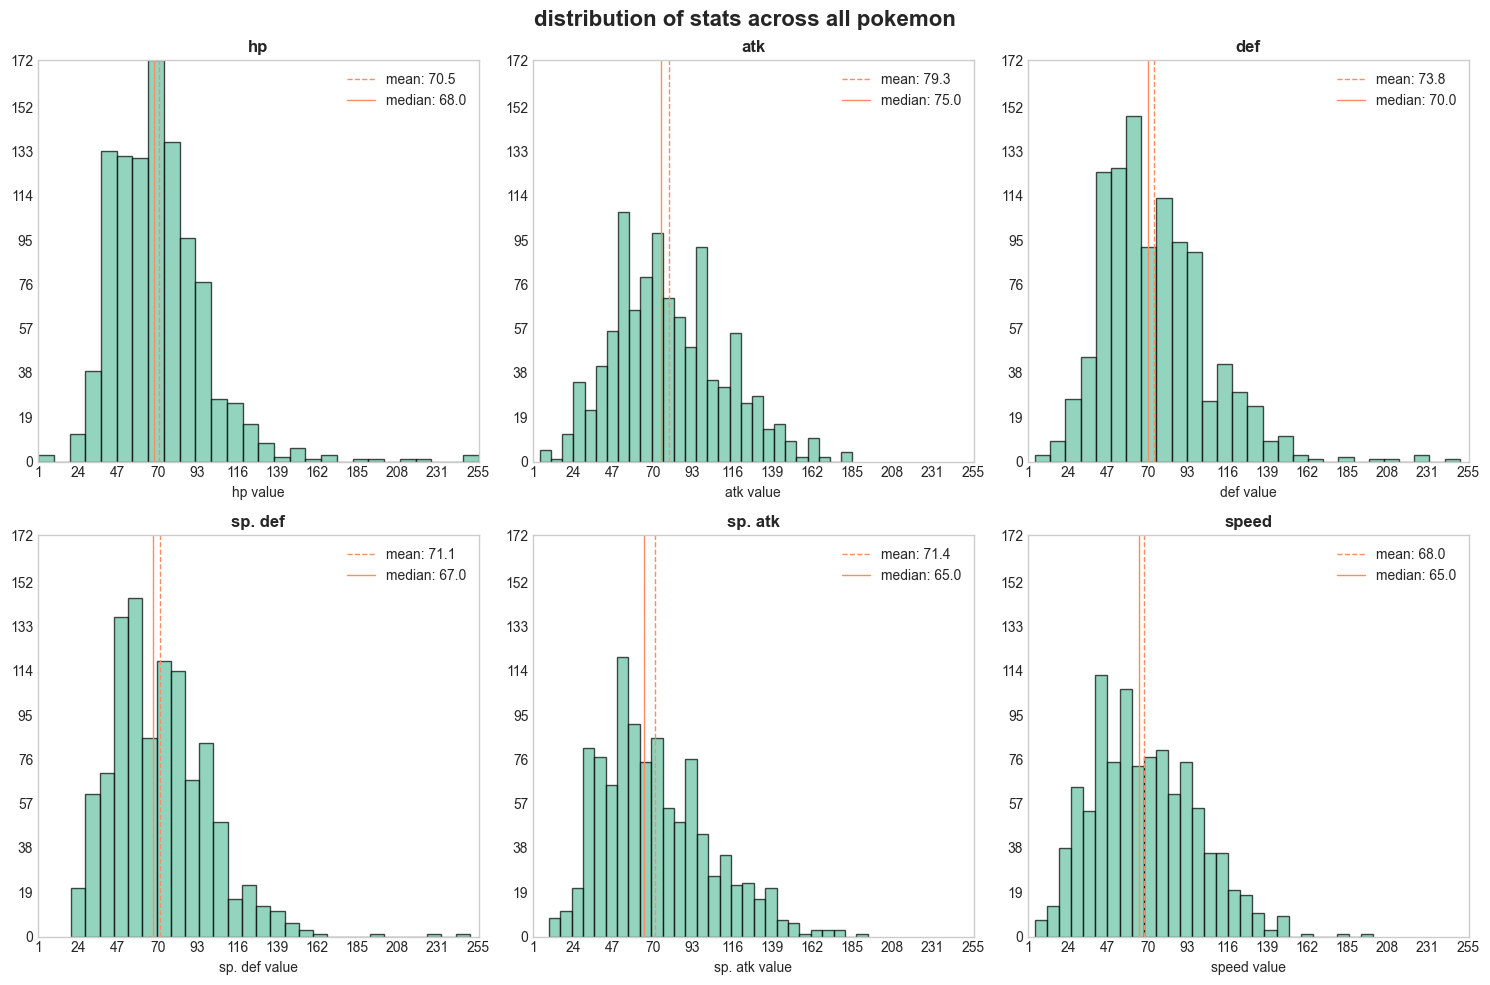

base stat summary statistics:


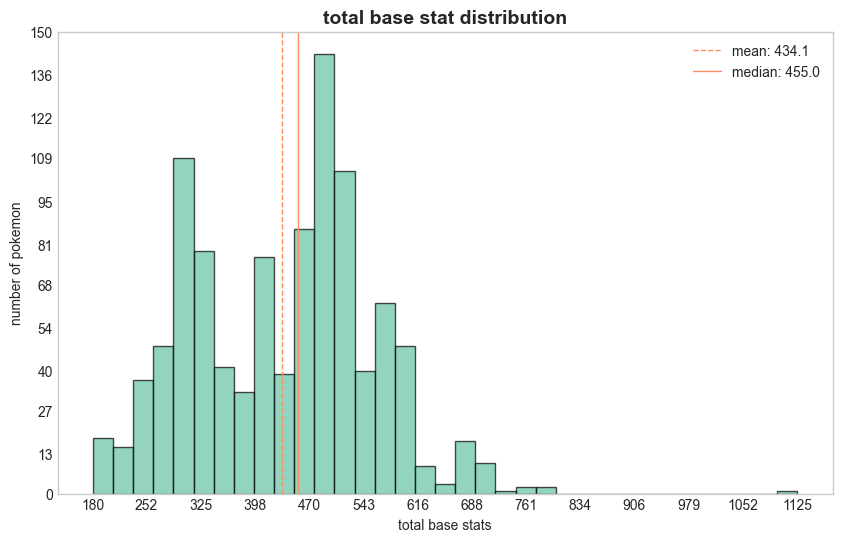

total base stats summary


,metric,value
0,average total stats,434.1
1,minimum total stats,180.0
2,maximum total stats,1125.0
3,standard deviation,120.6


In [6]:
# use base_stats_radar order for all stat plots, left-to-right (hp first, speed last)
base_stats_radar = [
    'Health Stat',         # hp
    'Attack Stat',         # atk
    'Defense Stat',        # def
    'Special Defense Stat',# sp. def
    'Special Attack Stat', # sp. atk
    'Speed Stat'           # speed
]
stat_labels = ['hp', 'atk', 'def', 'sp. def', 'sp. atk', 'speed']
stats_cols = base_stats_radar
stat_labels_plot = stat_labels

# calculate global min and max for x-axis across all stats
global_x_min = min(df_clean[stat].min() for stat in stats_cols)
global_x_max = max(df_clean[stat].max() for stat in stats_cols)

# calculate max y for all histograms for consistent height
max_y = 0
hist_data = []
for stat in stats_cols:
    counts, bins = np.histogram(df_clean[stat], bins=28)
    hist_data.append((counts, bins))
    if counts.max() > max_y:
        max_y = counts.max()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('distribution of stats across all pokemon', fontsize=16, fontweight='bold')

for i, (stat, label) in enumerate(zip(stats_cols, stat_labels_plot)):
    row, col = i // 3, i % 3
    axes[row, col].hist(df_clean[stat], bins=28, alpha=0.7, color=presentation_palette[0], edgecolor='black')
    axes[row, col].axvline(df_clean[stat].mean(), color=presentation_palette[1], linestyle='--', linewidth=1, label=f'mean: {df_clean[stat].mean():.1f}')
    axes[row, col].axvline(df_clean[stat].median(), color=presentation_palette[1], linestyle='-', linewidth=1, label=f'median: {df_clean[stat].median():.1f}')
    axes[row, col].set_title(f'{label}', fontweight='bold')
    axes[row, col].set_xlabel(f'{label} value')
    axes[row, col].set_ylabel('')
    axes[row, col].legend()
    axes[row, col].grid(False)
    axes[row, col].set_xticks(np.linspace(global_x_min, global_x_max, num=12, dtype=int))
    axes[row, col].set_yticks(np.linspace(0, max_y, num=10, dtype=int))
    axes[row, col].set_ylim(0, max_y)
    axes[row, col].set_xlim(global_x_min, global_x_max)

plt.tight_layout()
plt.savefig('figures/distribution/base_stats_distributions.png', dpi=800, bbox_inches='tight')
plt.show()

# summary statistics table
print("base stat summary statistics:")
stats_summary = df_clean[stats_cols].describe().round(1)
stats_summary

# total base stat distribution (fewer bins, more ticks, no grid)
plt.figure(figsize=(10, 6))
plt.hist(df_clean['Base Stat Total'], bins=35, alpha=0.7, color=presentation_palette[0], edgecolor='black')
plt.axvline(df_clean['Base Stat Total'].mean(), color=presentation_palette[1], linestyle='--', linewidth=1,
            label=f'mean: {df_clean["Base Stat Total"].mean():.1f}')
plt.axvline(df_clean['Base Stat Total'].median(), color=presentation_palette[1], linestyle='-', linewidth=1,
            label=f'median: {df_clean["Base Stat Total"].median():.1f}')
plt.title('total base stat distribution', fontsize=14, fontweight='bold')
plt.xlabel('total base stats')
plt.ylabel('number of pokemon')
plt.legend()
plt.grid(False)
x_min, x_max = int(df_clean['Base Stat Total'].min()), int(df_clean['Base Stat Total'].max())
plt.xticks(np.linspace(x_min, x_max, num=14, dtype=int))
plt.yticks(np.linspace(0, plt.gca().get_ylim()[1], num=12, dtype=int))
plt.savefig('figures/distribution/total_base_stat_distribution.png', dpi=800, bbox_inches='tight')
plt.show()

# total stats summary table
total_stats_summary = pd.DataFrame({
    'metric': [
        'average total stats',
        'minimum total stats',
        'maximum total stats',
        'standard deviation'
    ],
    'value': [
        round(df_clean['Base Stat Total'].mean(), 1),
        df_clean['Base Stat Total'].min(),
        df_clean['Base Stat Total'].max(),
        round(df_clean['Base Stat Total'].std(), 1)
    ]
})
print("total base stats summary")
total_stats_summary


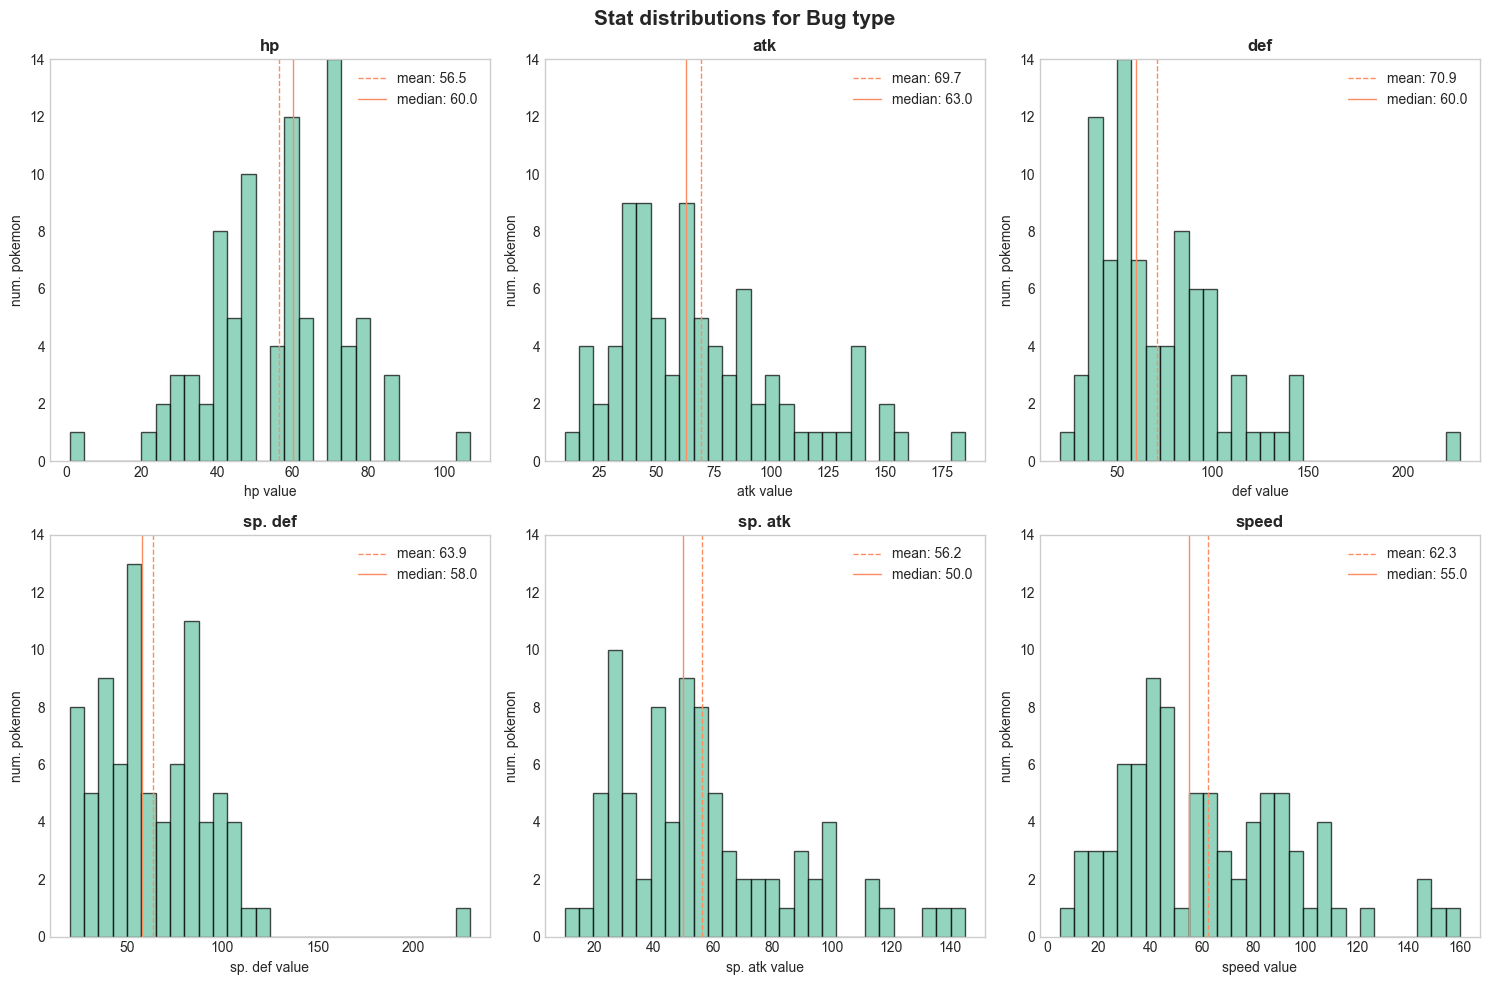

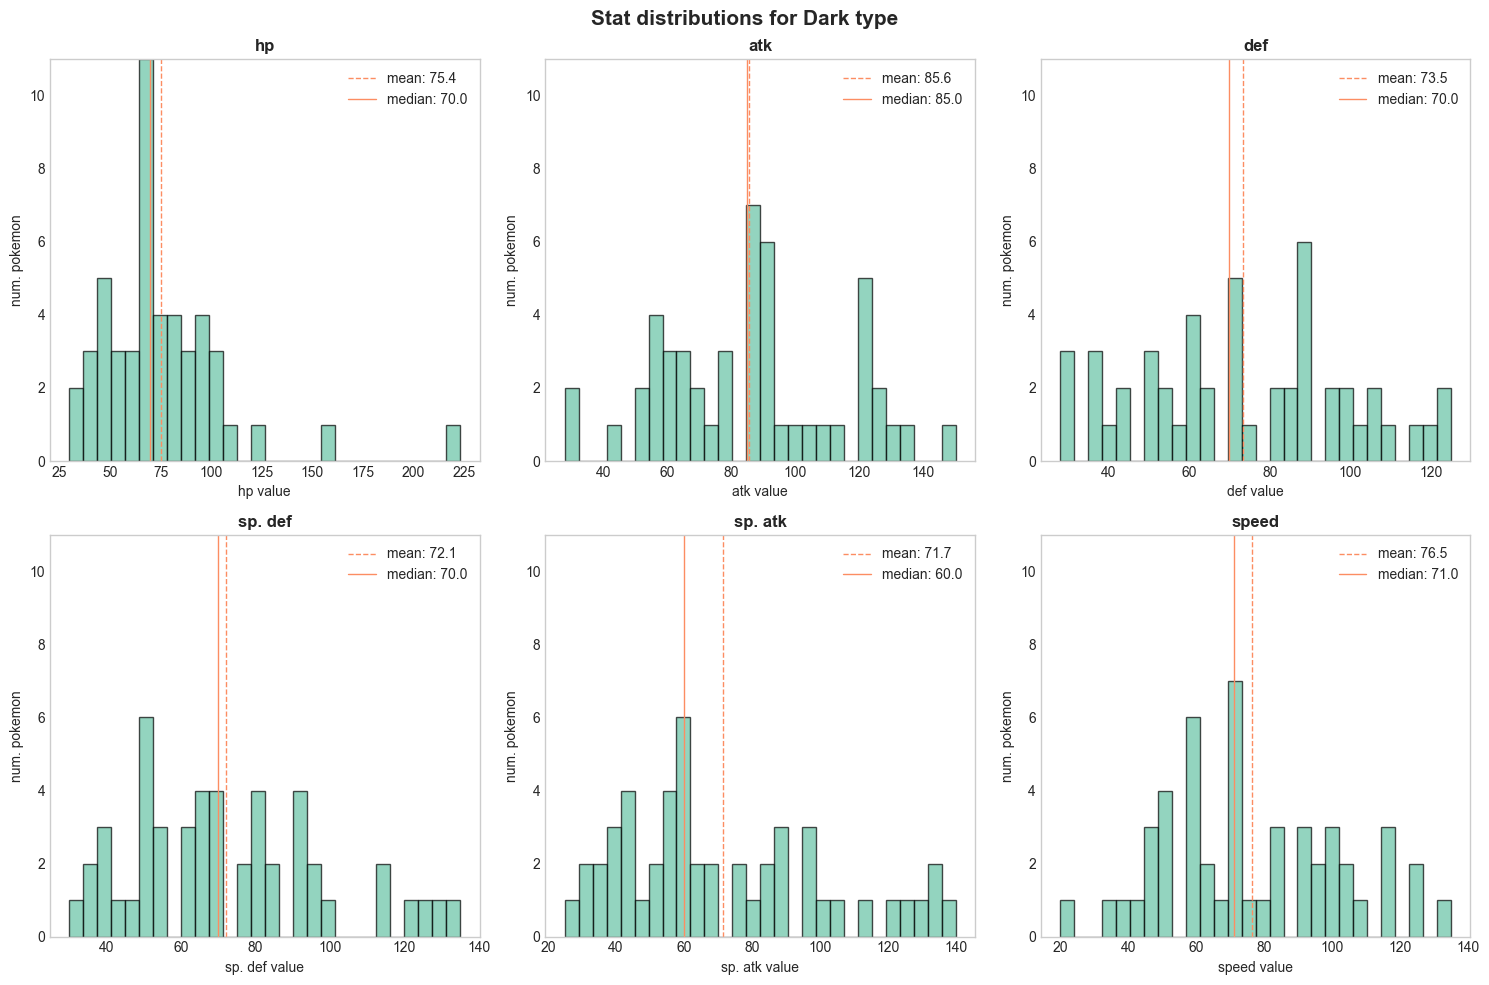

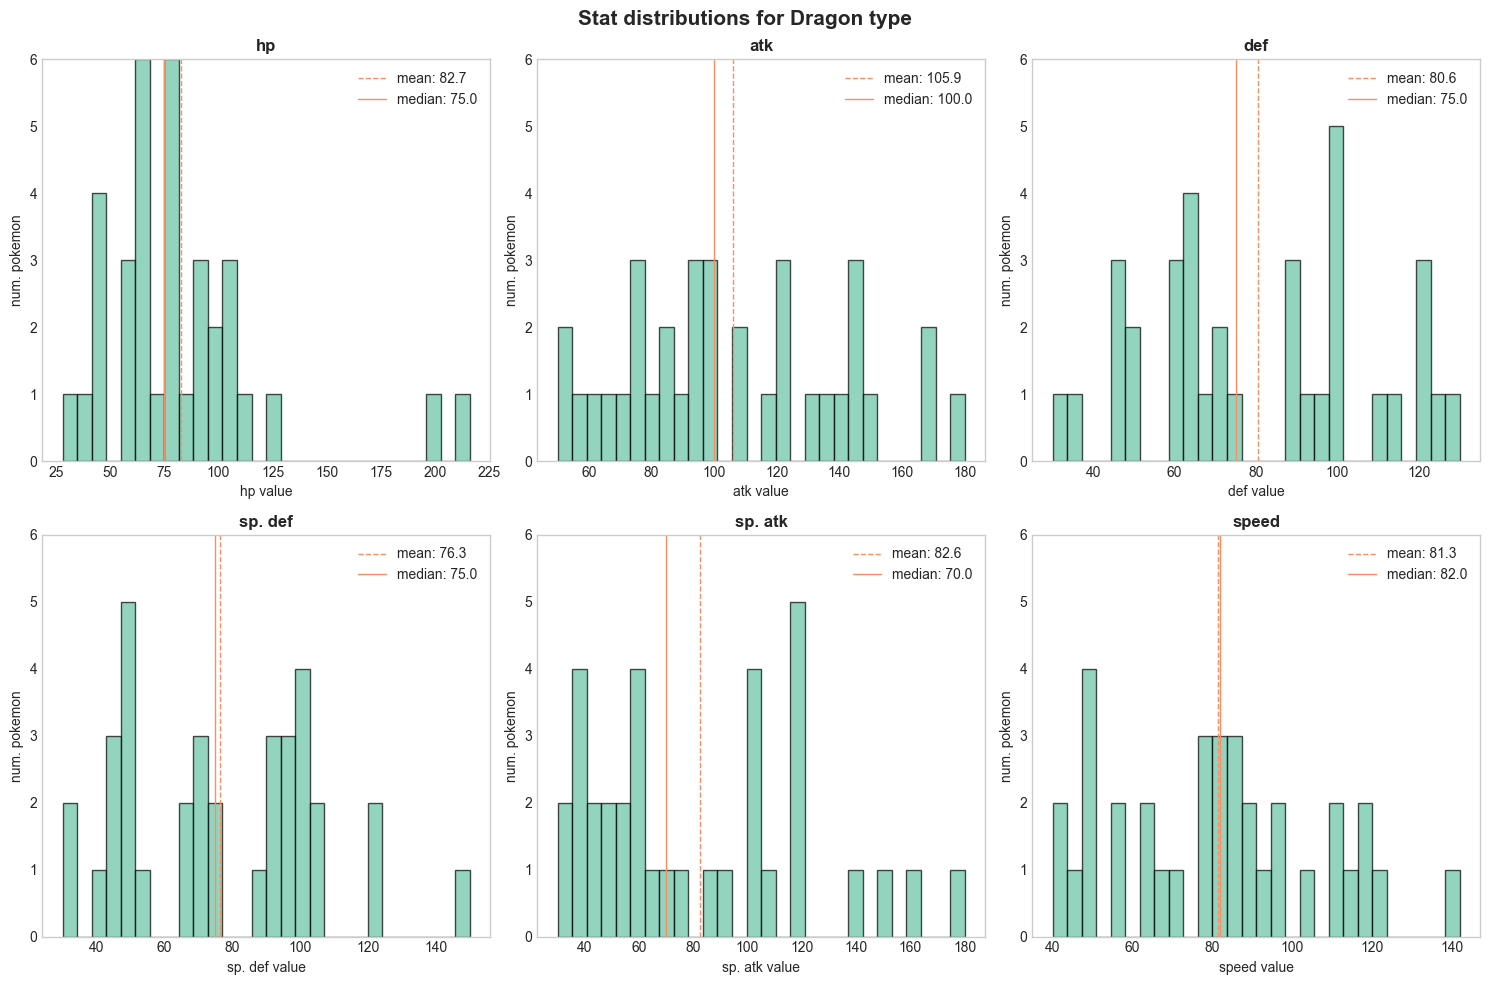

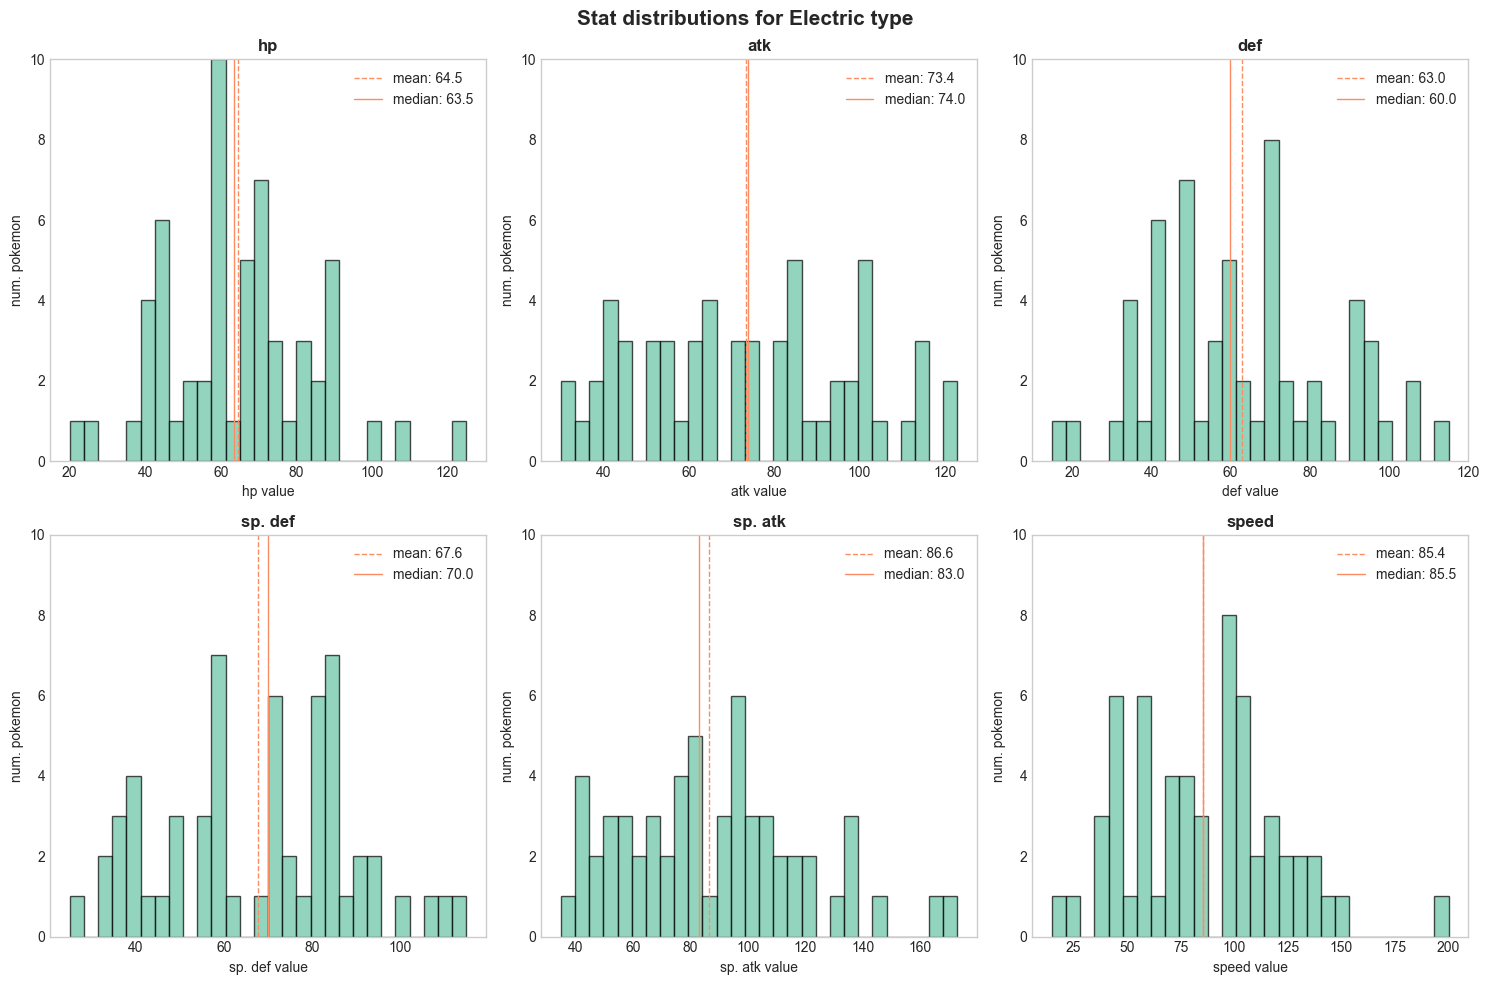

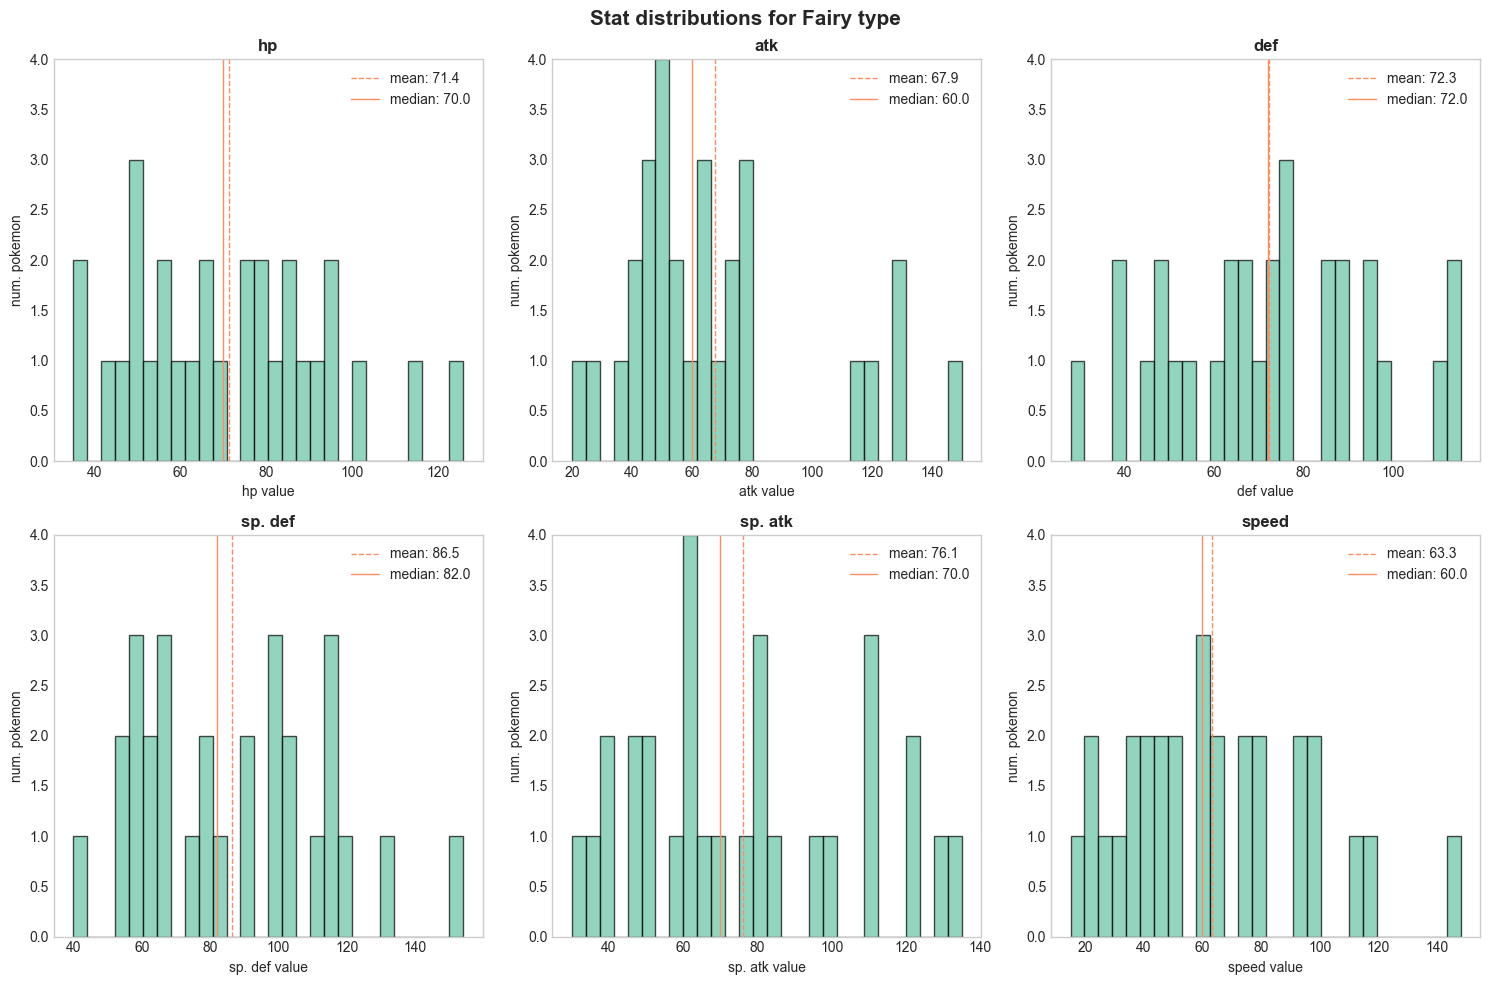

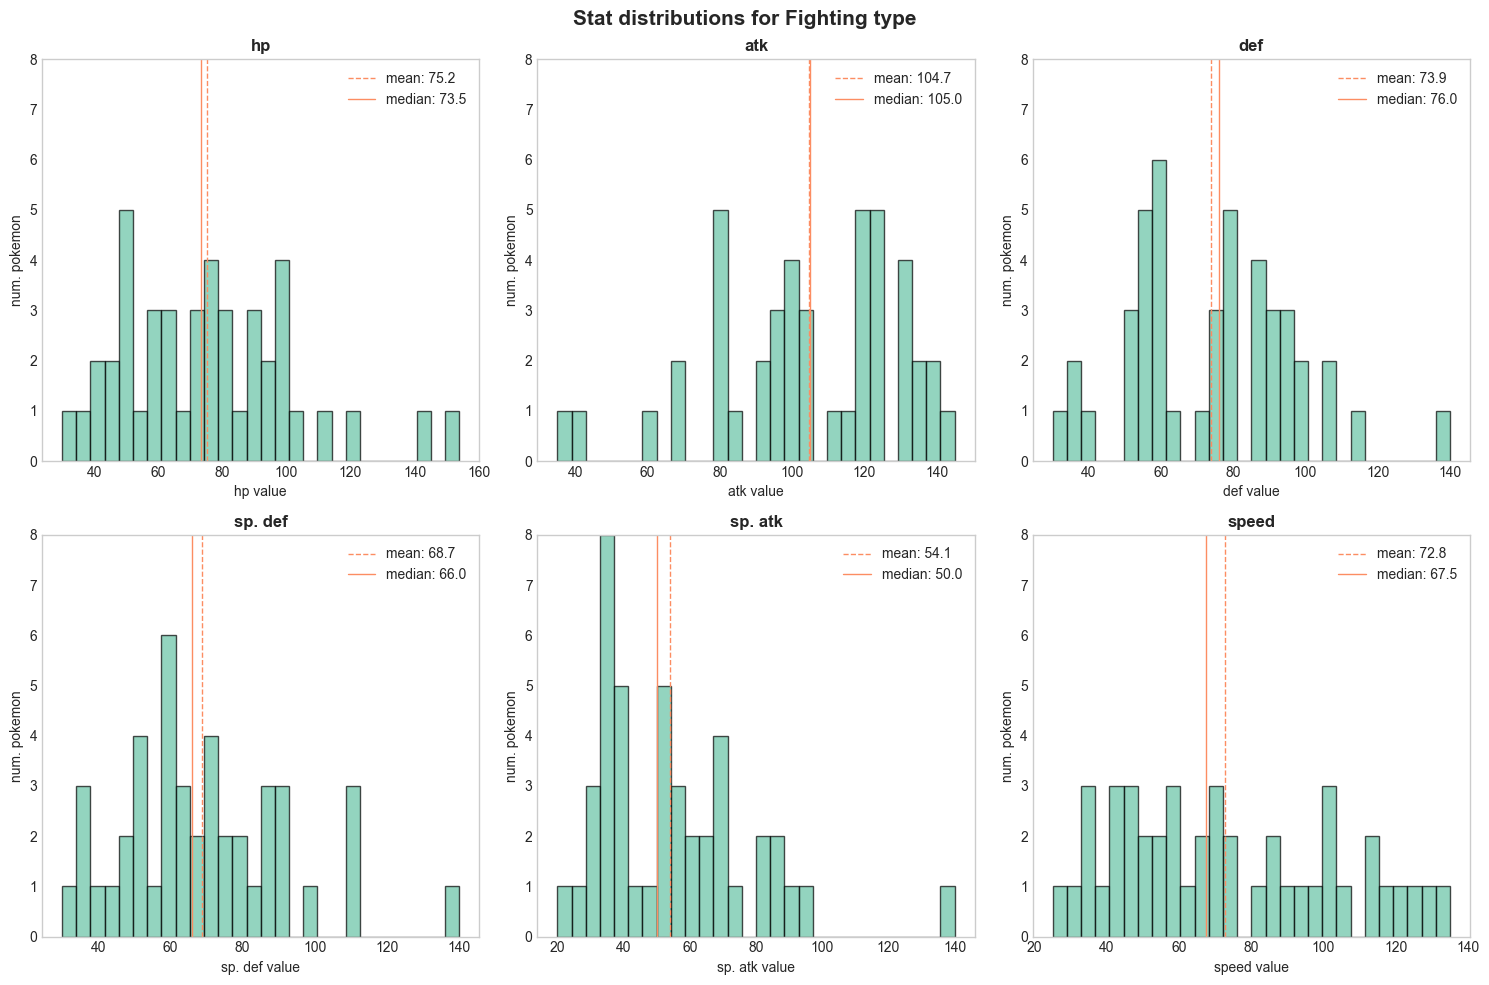

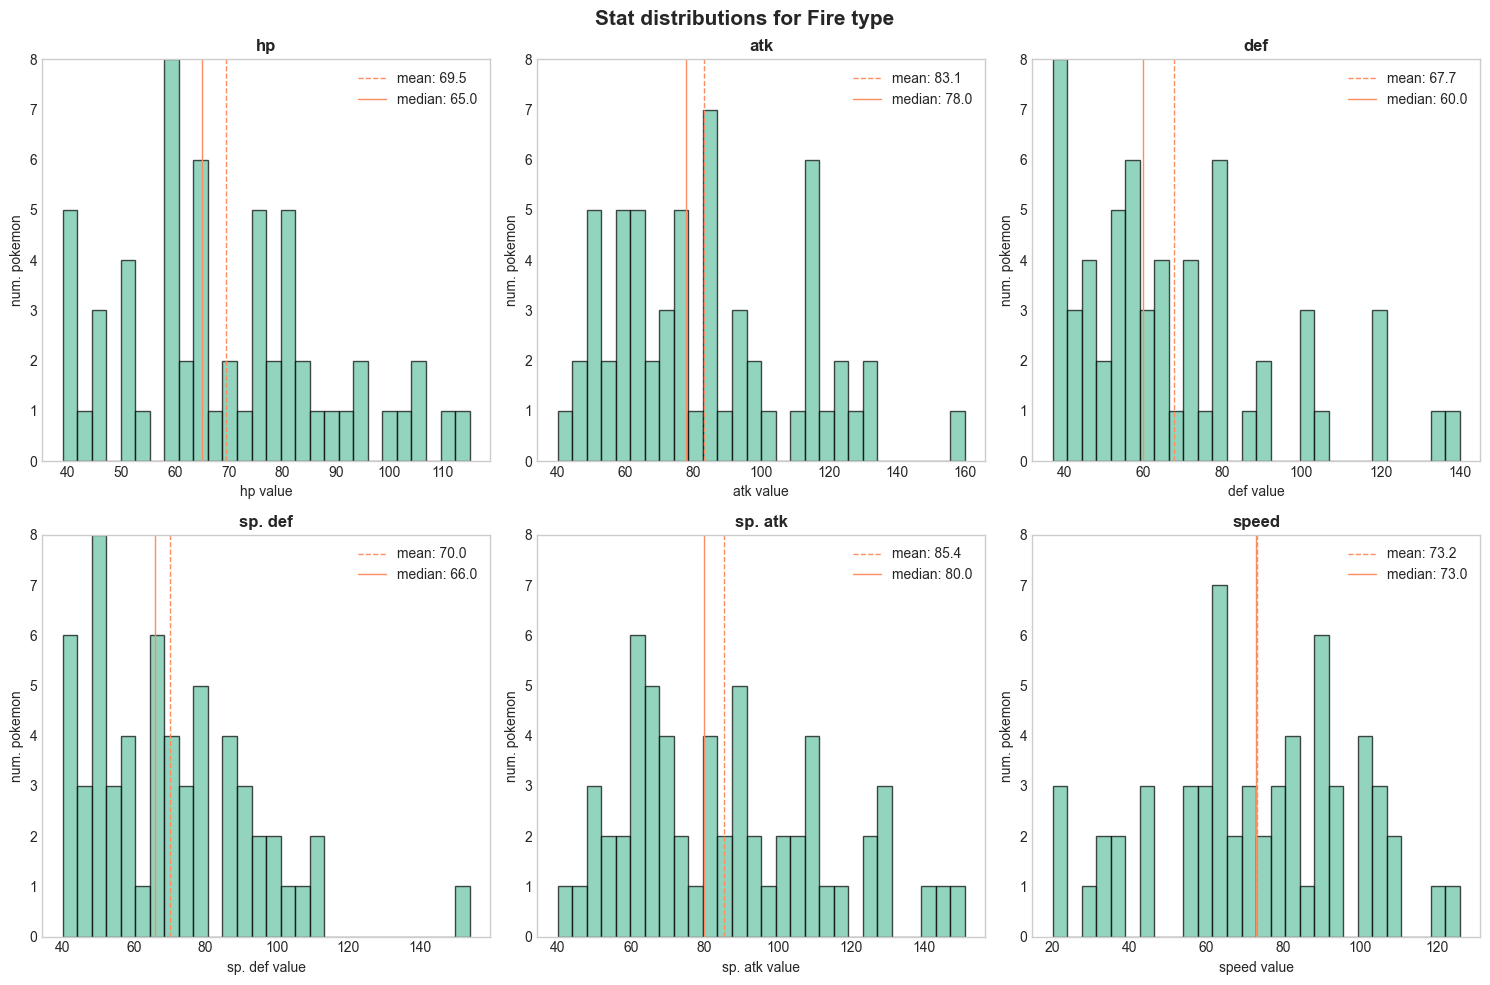

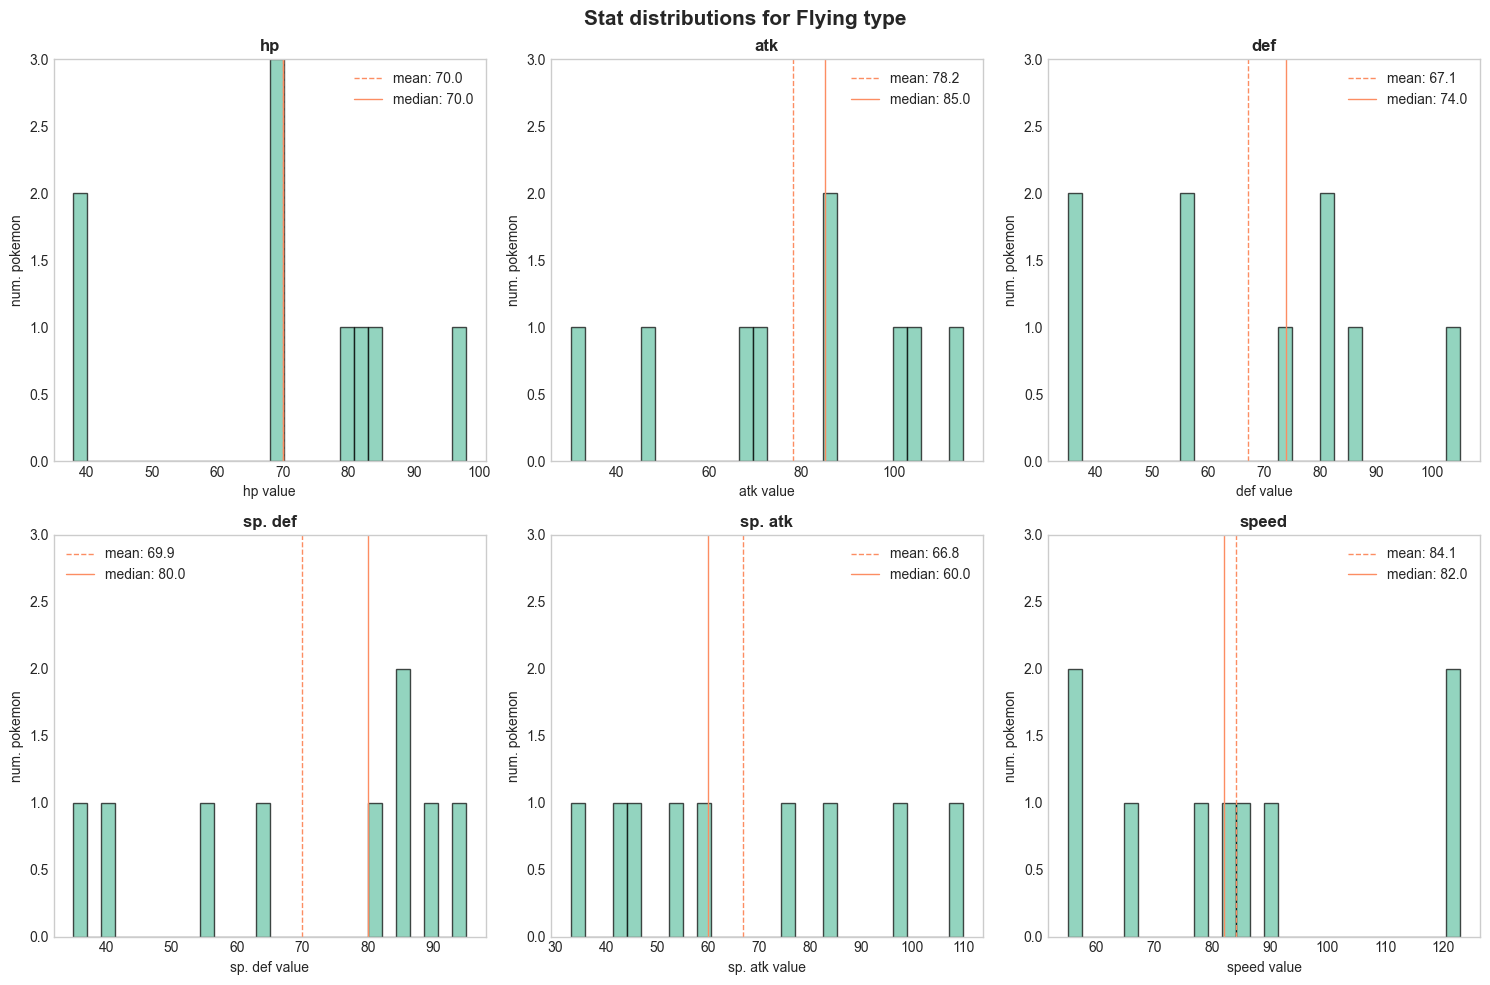

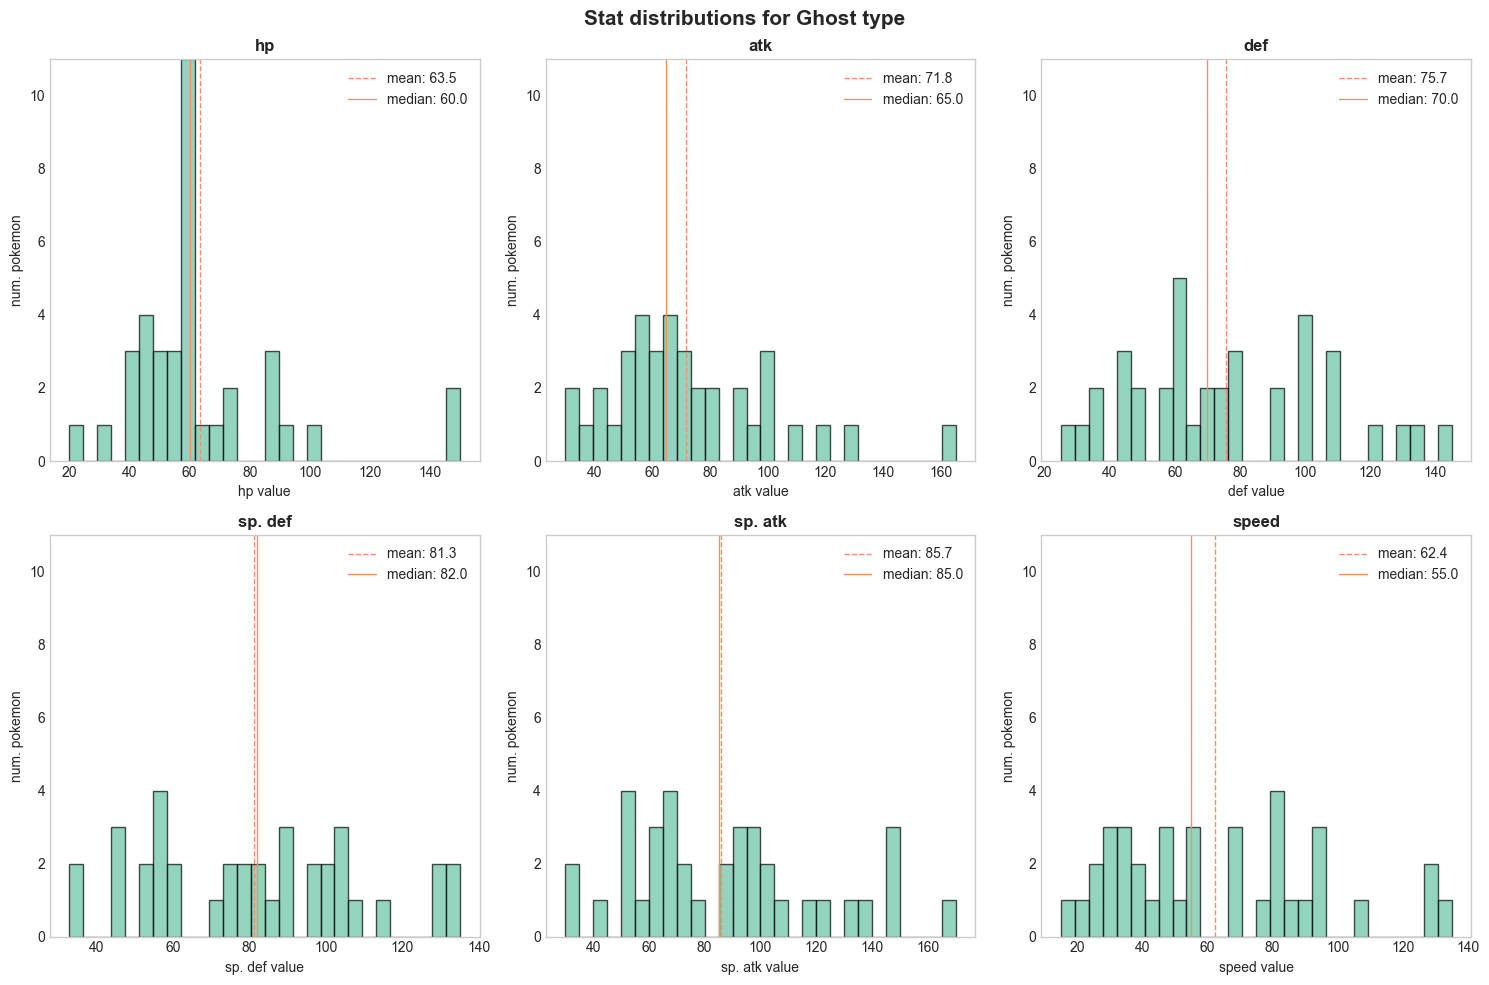

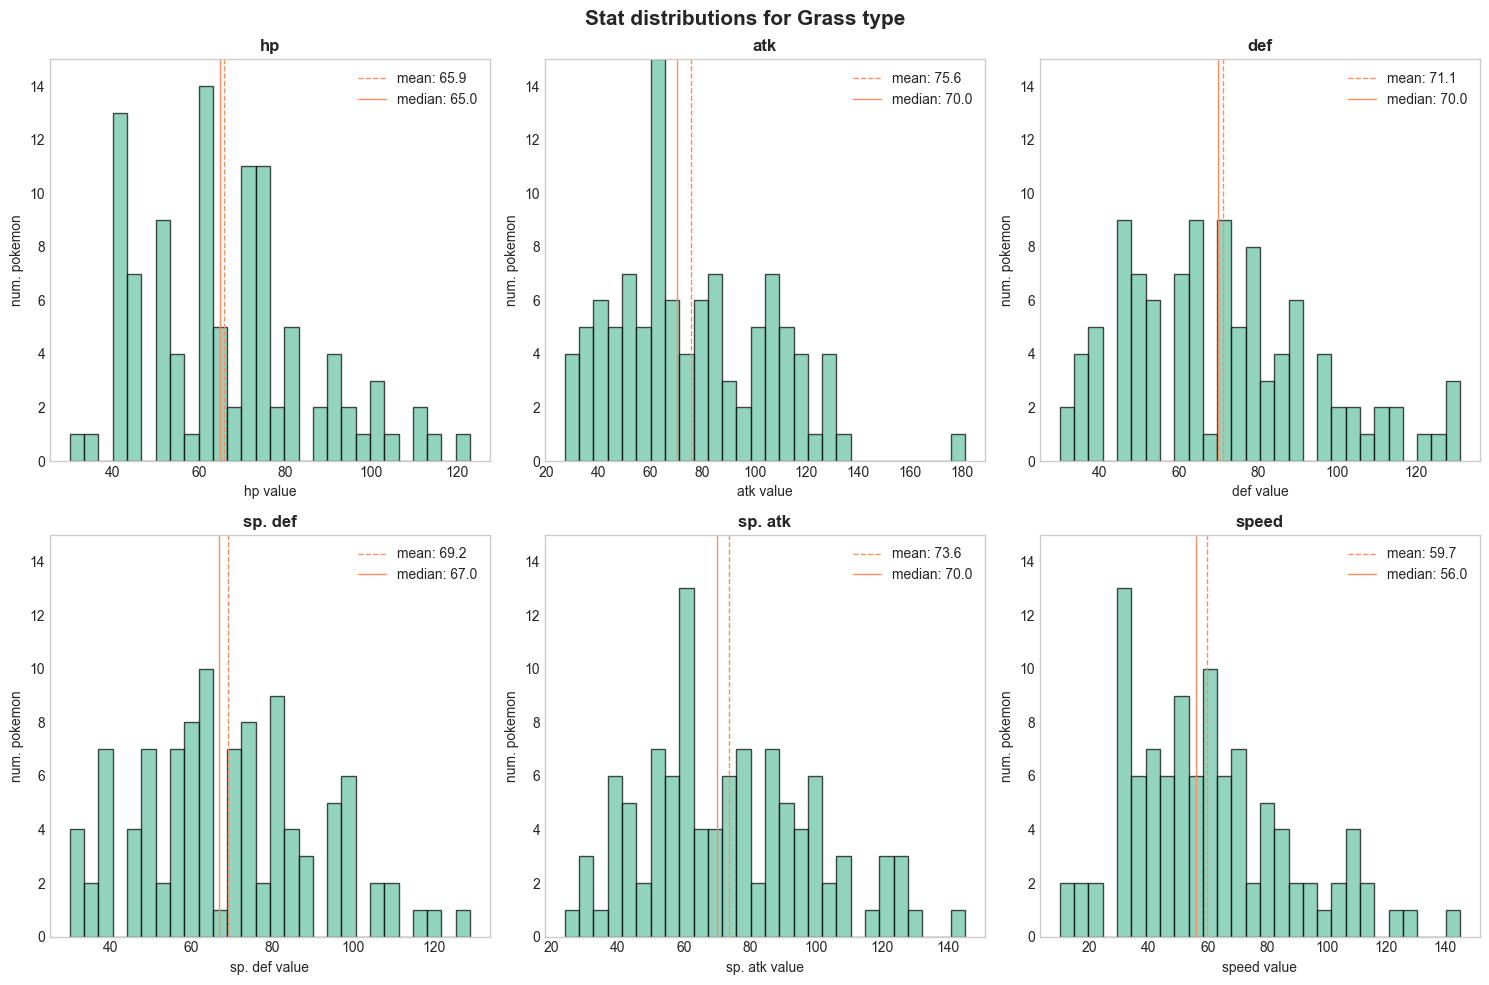

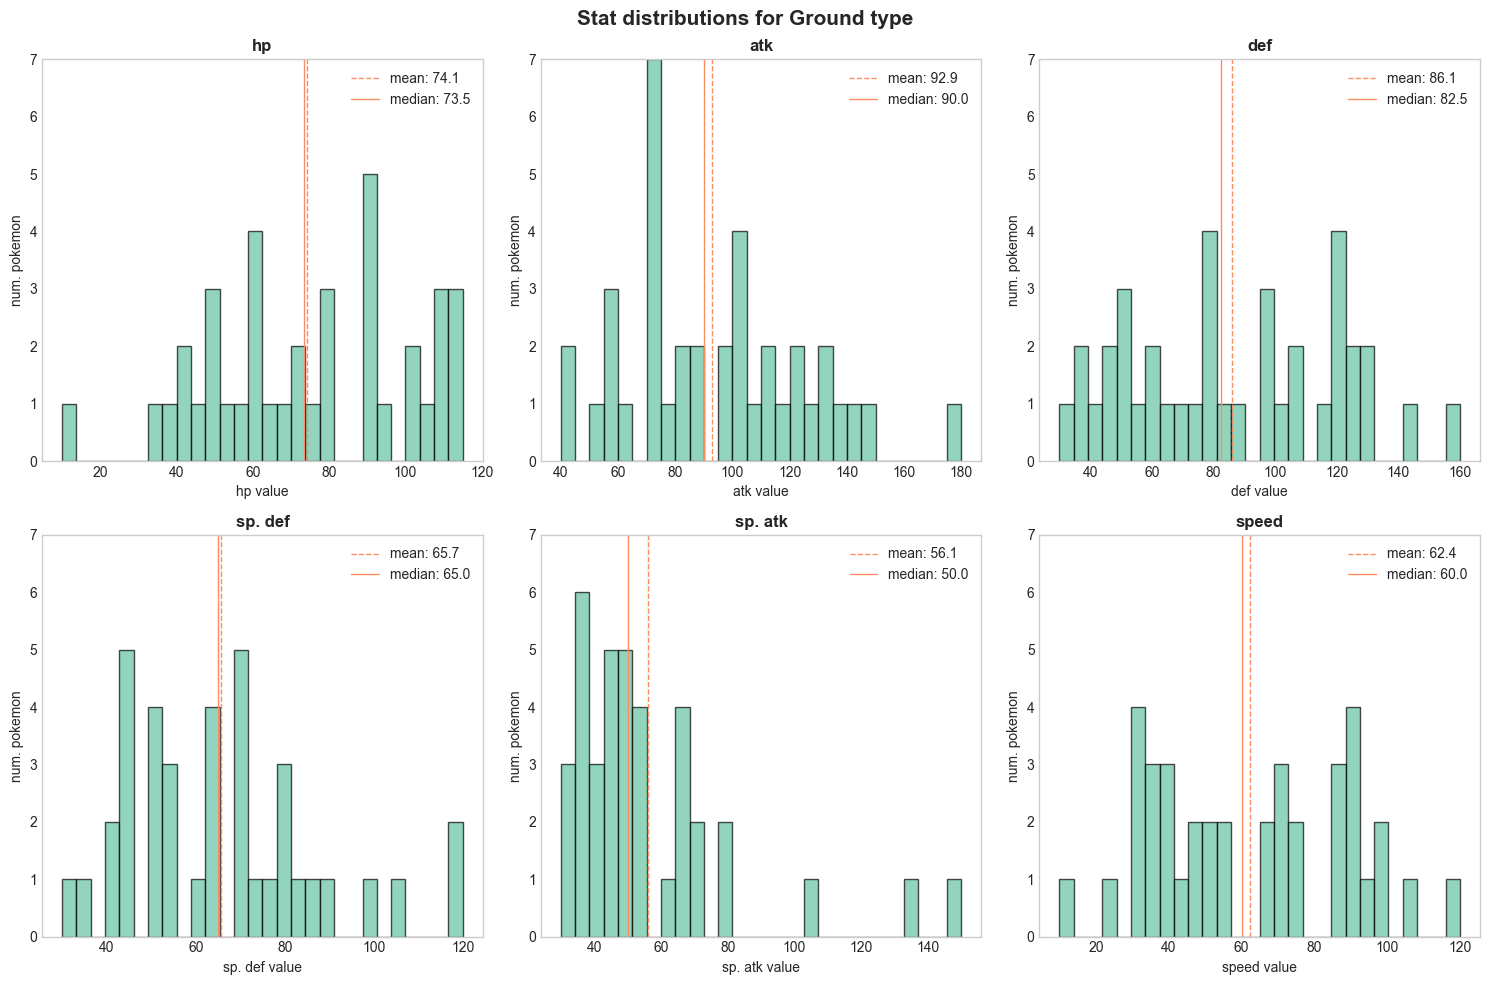

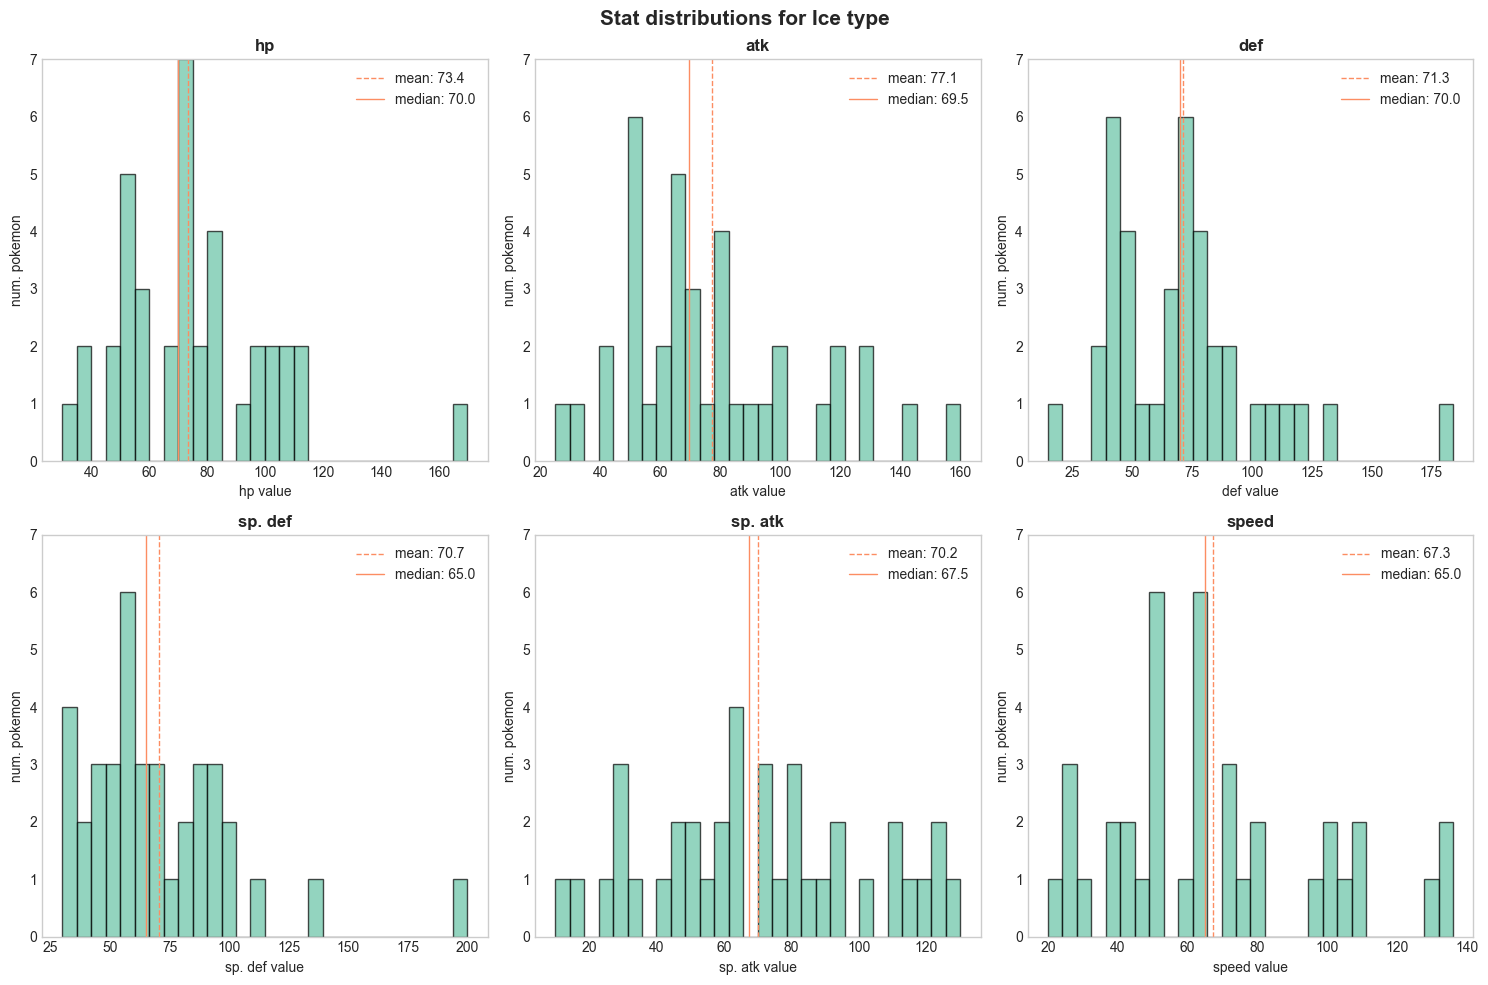

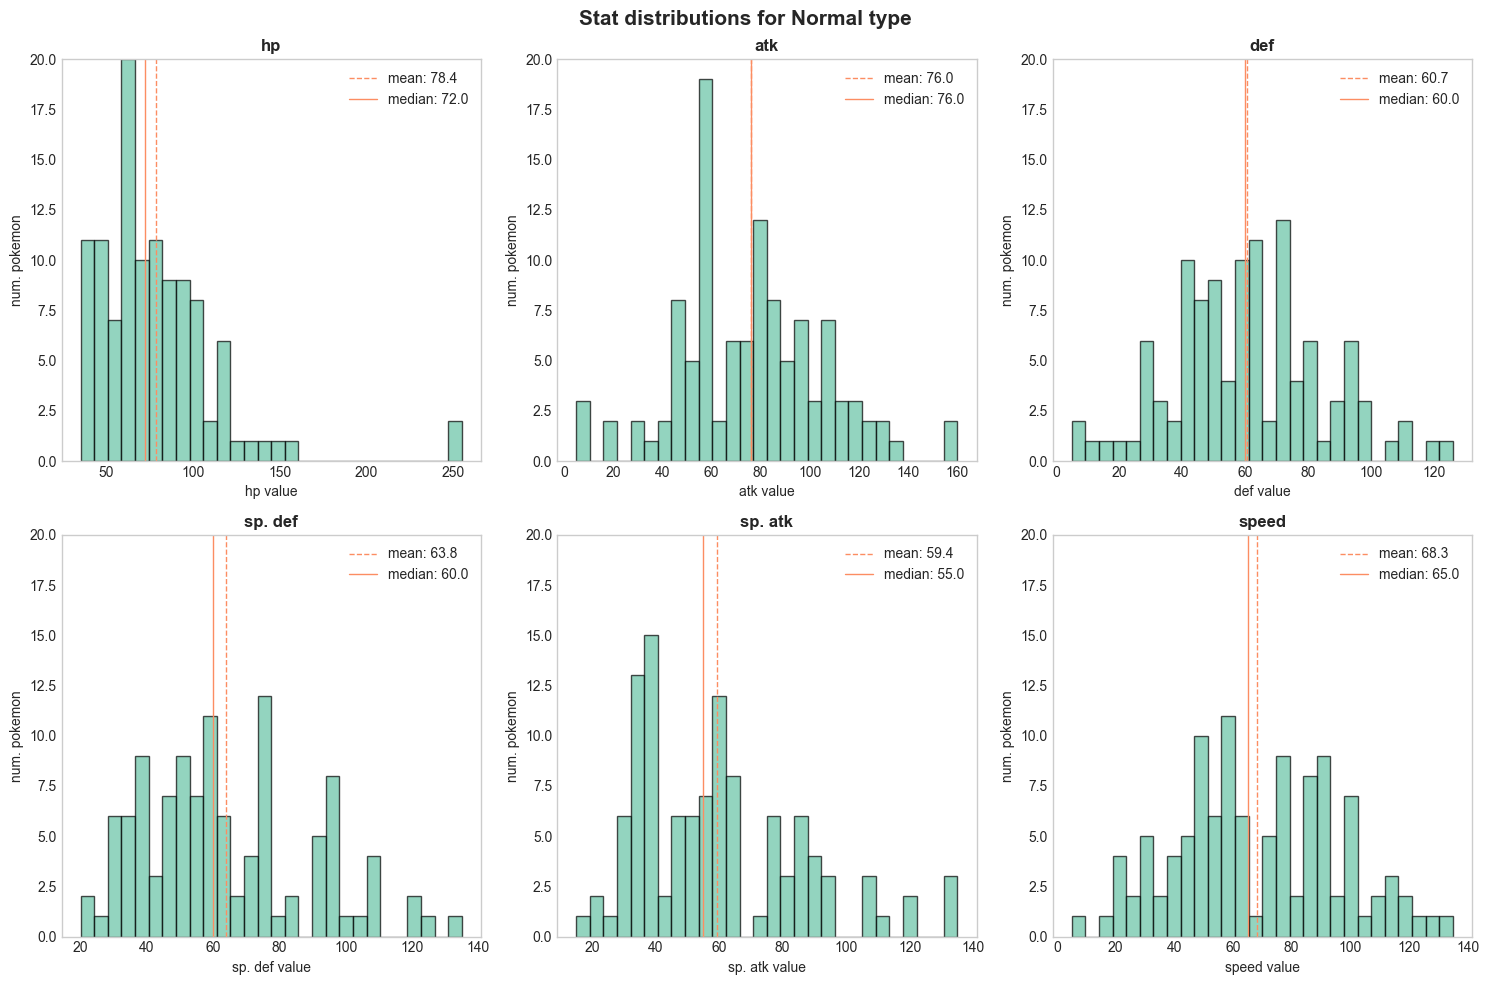

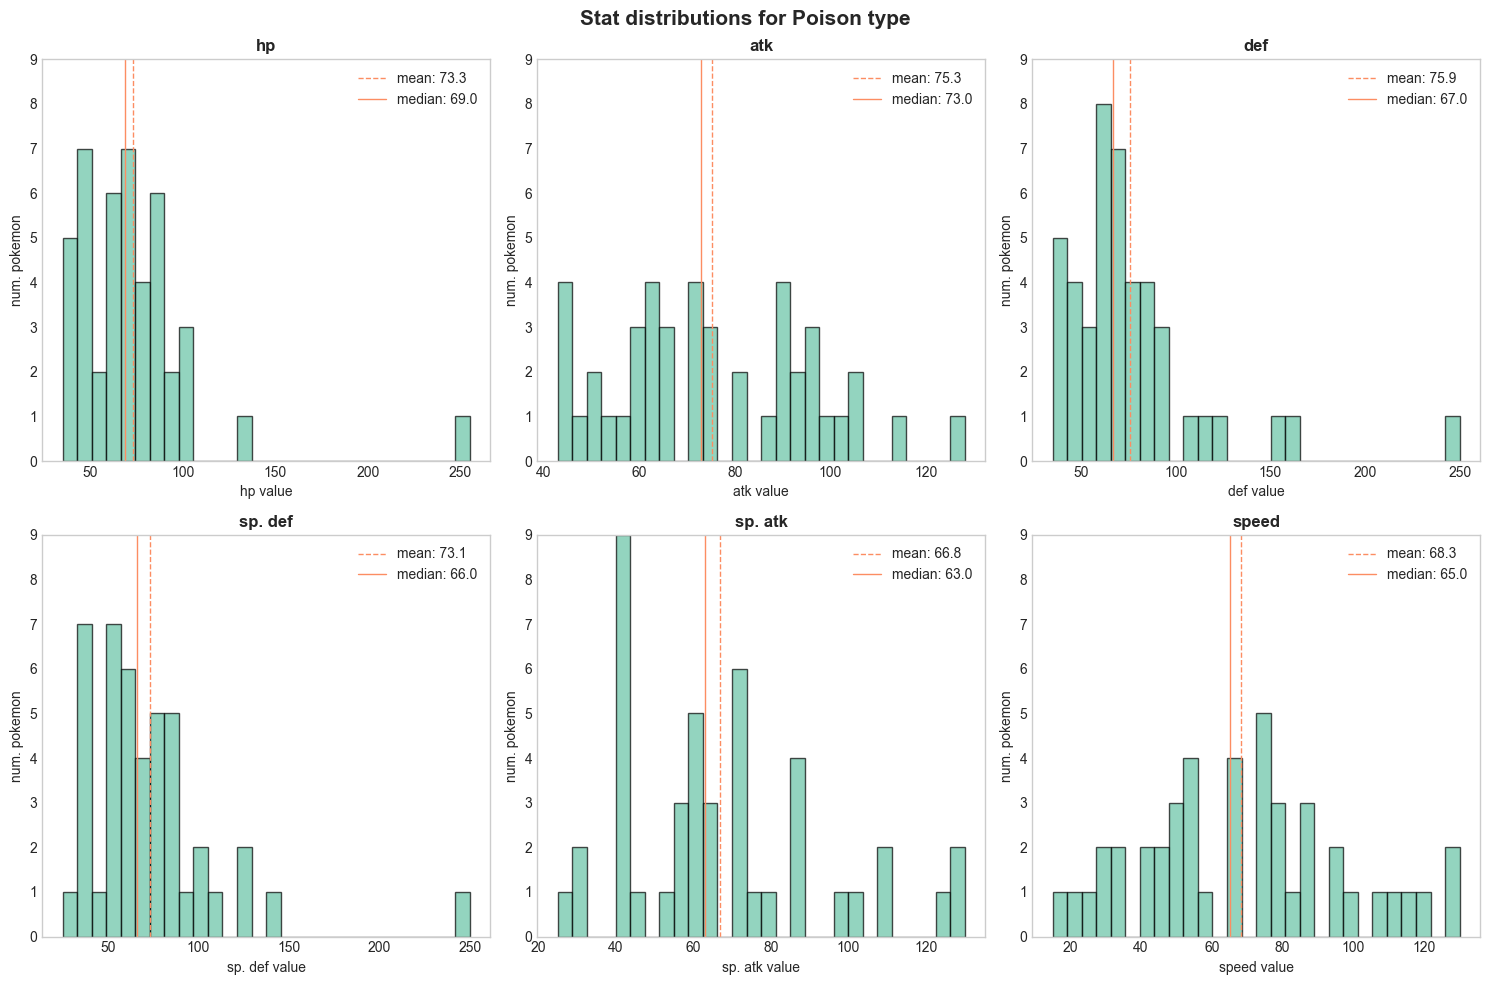

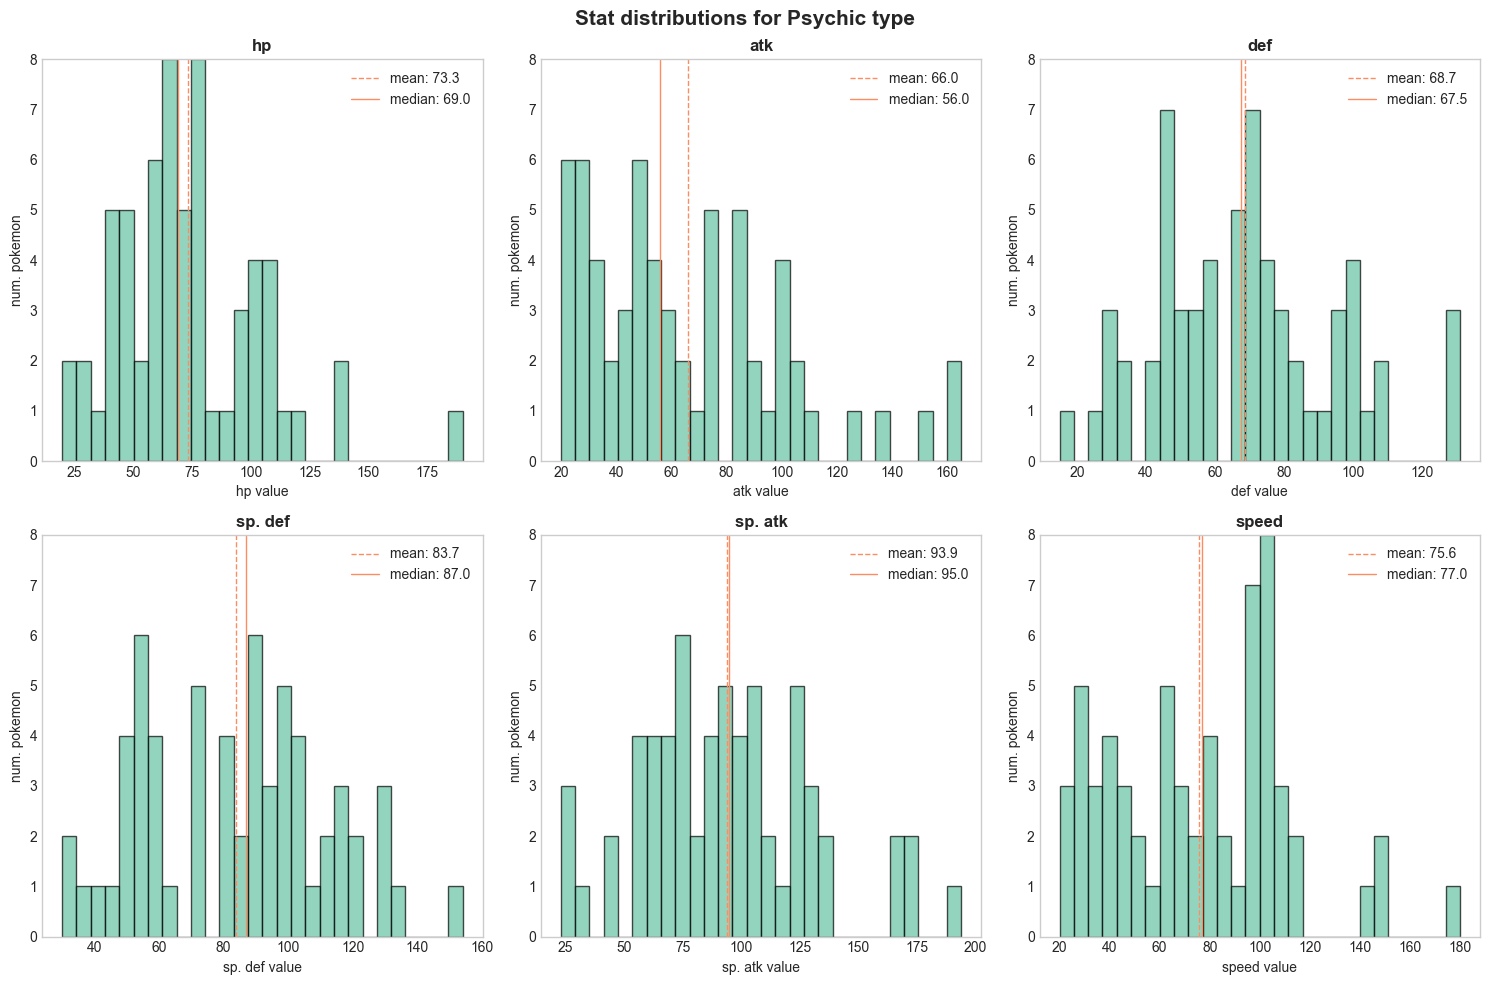

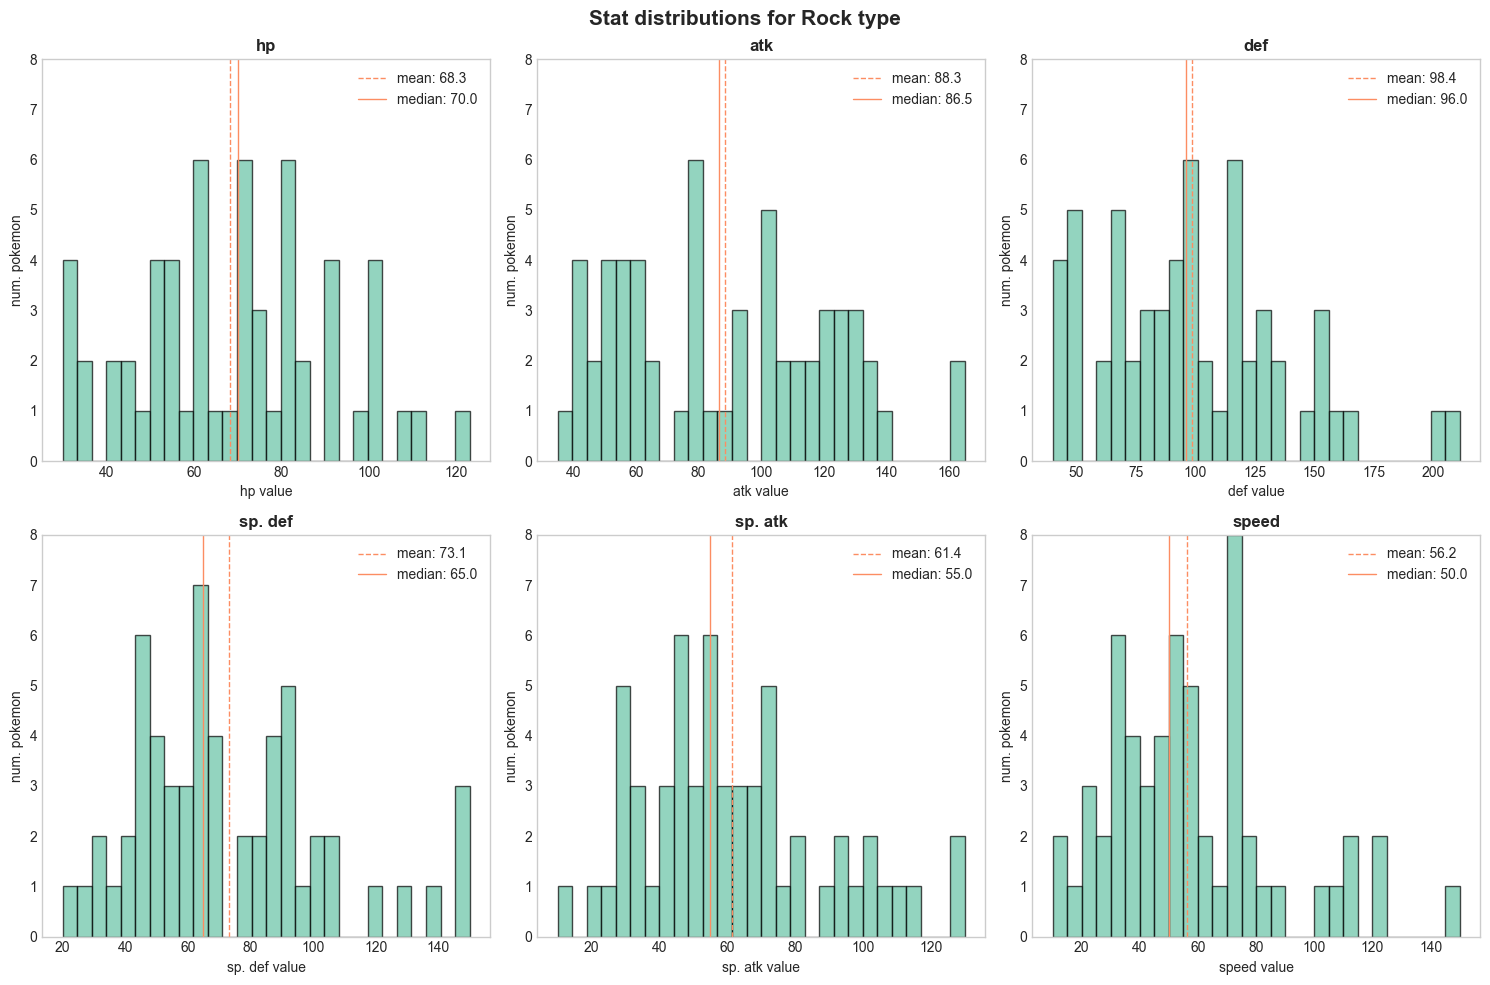

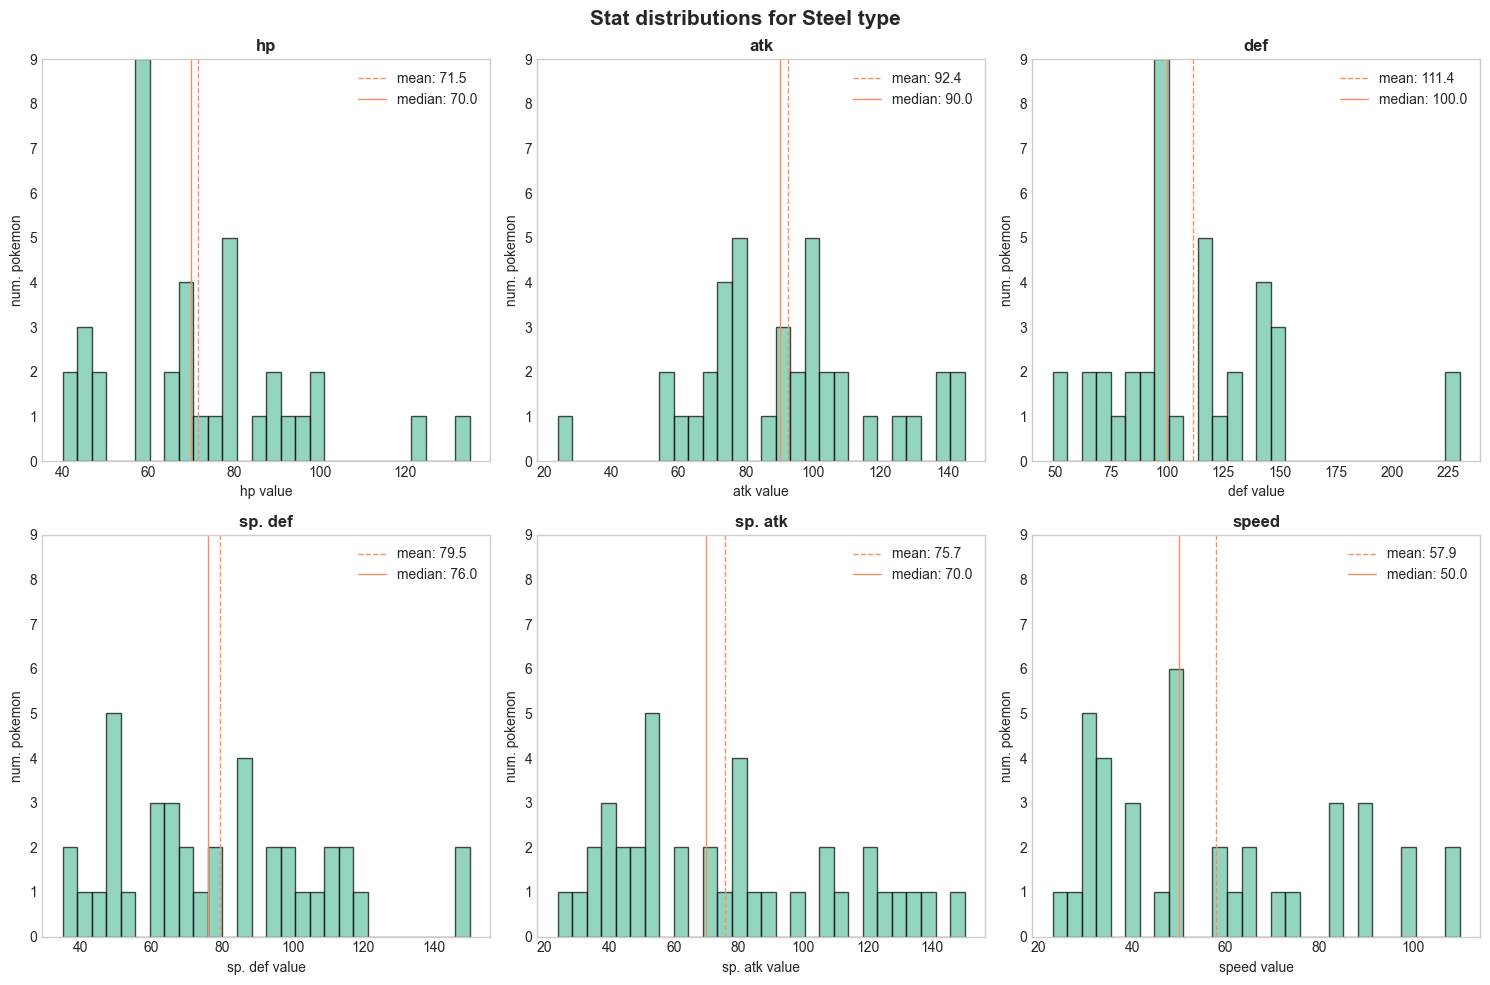

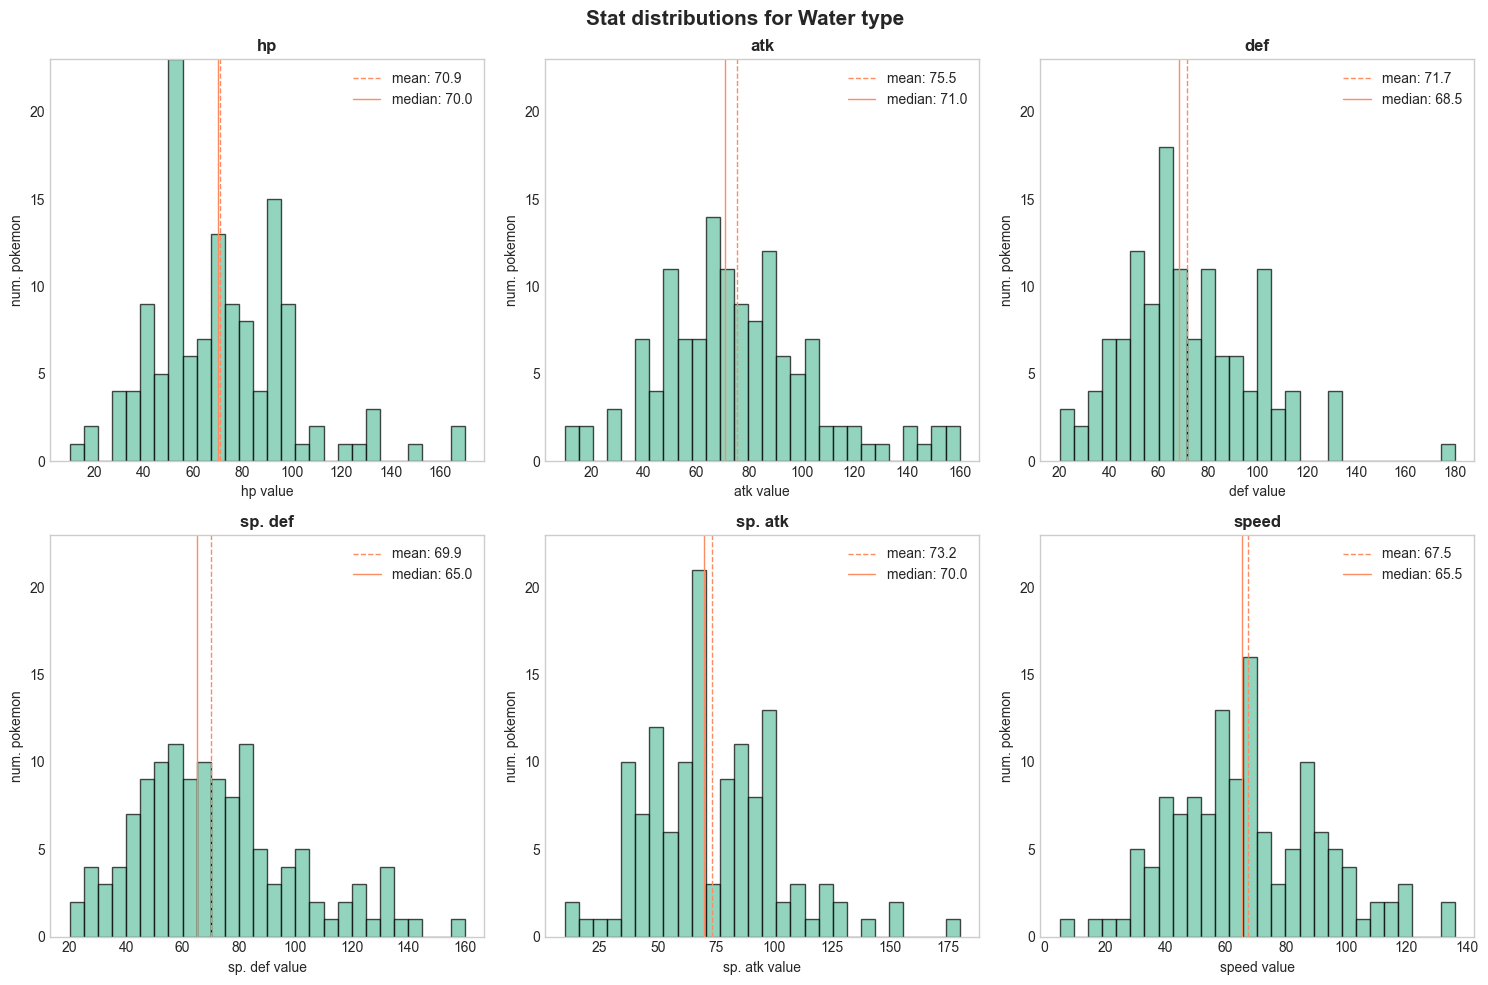

In [7]:
# --- ALL STAT DISTRIBUTIONS FOR EACH PRIMARY TYPE (SUBPLOTS, CONSISTENT Y AXIS, MEAN & MEDIAN LINES) ---
base_stats_radar = [
    'Health Stat', 'Attack Stat', 'Defense Stat', 'Special Defense Stat', 'Special Attack Stat', 'Speed Stat'
 ]
stat_labels = ['hp', 'atk', 'def', 'sp. def', 'sp. atk', 'speed']
primary_types = sorted(df_clean['Primary Type'].unique())
for ptype in primary_types:
    subset = df_clean[df_clean['Primary Type'] == ptype]
    # find max y across all stats for this type
    max_y = 0
    for stat in base_stats_radar:
        counts, _ = np.histogram(subset[stat], bins=28)
        if counts.max() > max_y:
            max_y = counts.max()
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Stat distributions for {ptype} type', fontsize=15, fontweight='bold')
    for i, (stat, label) in enumerate(zip(base_stats_radar, stat_labels)):
        row, col = i // 3, i % 3
        axes[row, col].hist(subset[stat], bins=28, alpha=0.7, color=presentation_palette[0], edgecolor='black')
        # add mean and median lines (same style as previous cell)
        axes[row, col].axvline(subset[stat].mean(), color=presentation_palette[1], linestyle='--', linewidth=1, label=f'mean: {subset[stat].mean():.1f}')
        axes[row, col].axvline(subset[stat].median(), color=presentation_palette[1], linestyle='-', linewidth=1, label=f'median: {subset[stat].median():.1f}')
        axes[row, col].set_title(label, fontweight='bold')
        axes[row, col].set_xlabel(f'{label} value')
        axes[row, col].set_ylabel('num. pokemon')
        axes[row, col].set_ylim(0, max_y)
        axes[row, col].legend()
        axes[row, col].grid(False)
    plt.tight_layout()
    plt.savefig(f'figures/distribution/all_stats_{ptype}_type.png', dpi=800, bbox_inches='tight')
    plt.show()

## Legendary vs Normal Pokemon Comparison

normal vs legendary pokemon


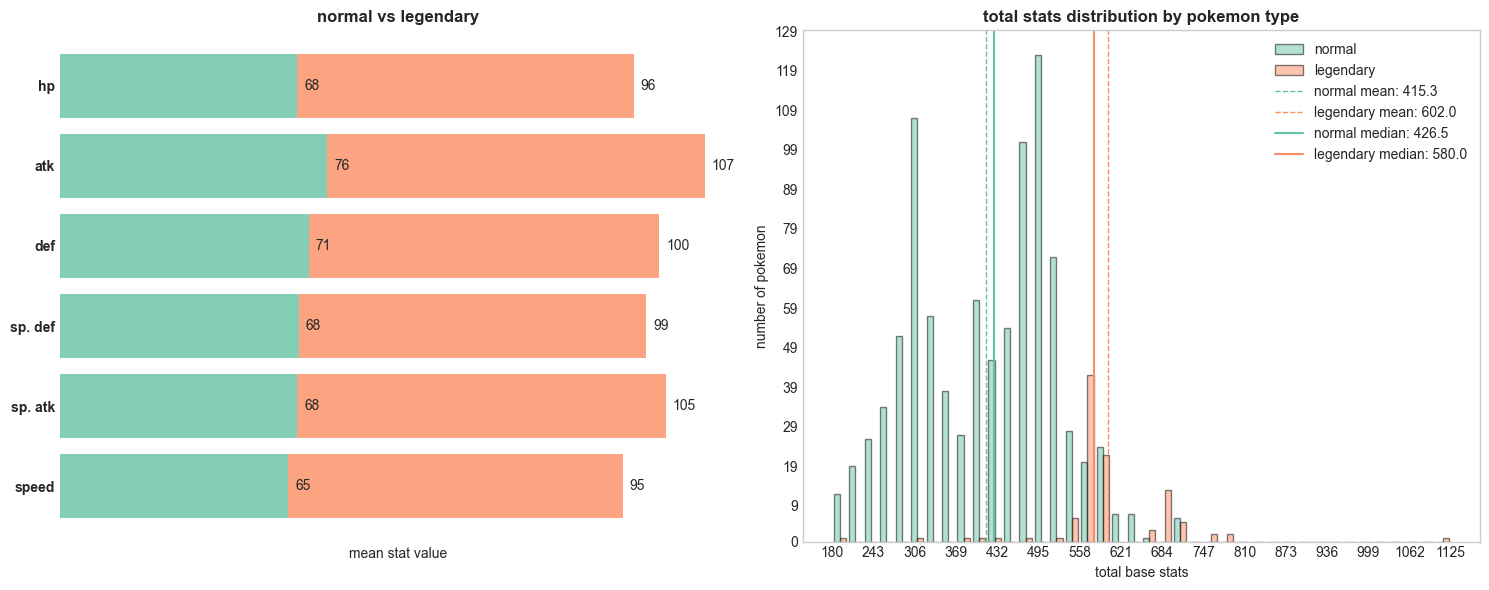


legendary pokemon have on average 186.7 more total stats than normal pokemon
strongest legendary stat boost: special attack stat (+37.3)

lowest and highest legendary outlier analysis:
Lowest: "Cosmog" ("Legendary") - total stats: 200
Highest: "Eternatus" ("Legendary") - total stats: 1125
Lowest is -380.0 points below the median legendary pokemon
Highest is 545.0 points above the median legendary pokemon


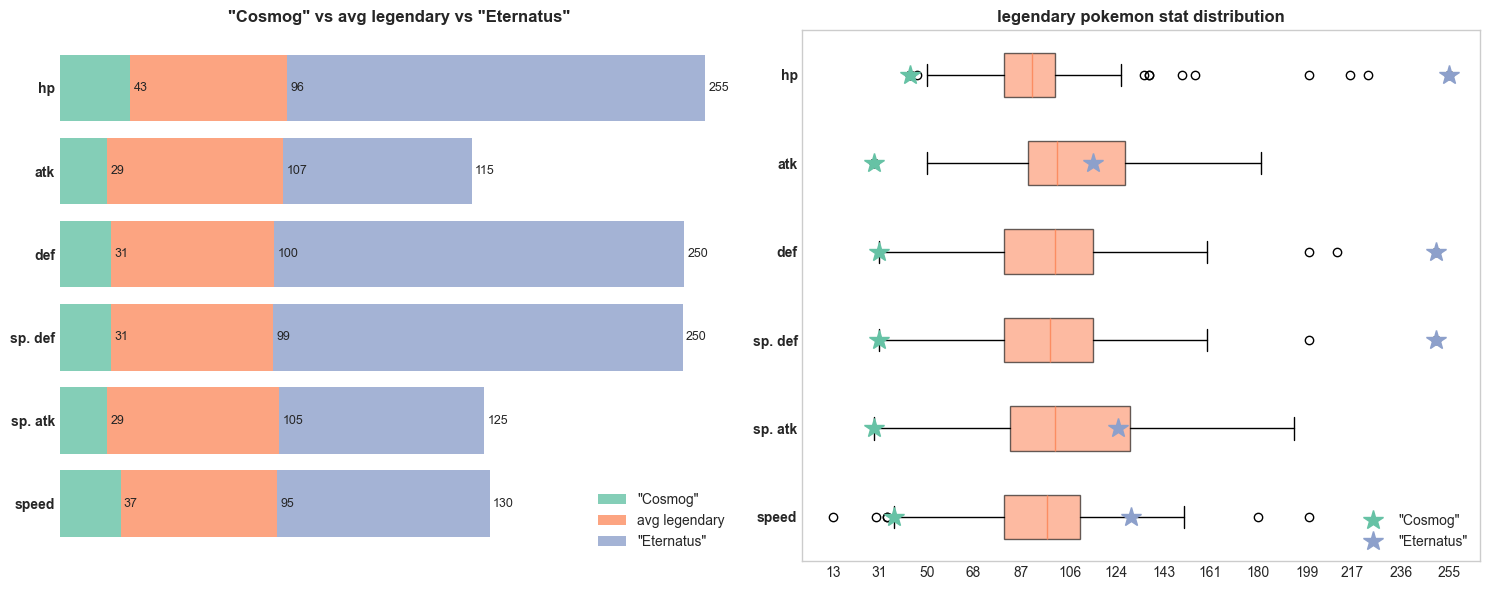

Legendary with lowest speed: "Stakataka" ("Sub-Legendary") - speed: 13


In [8]:
# compare legendary vs normal pokemon stats
base_stats_radar = [
    'Health Stat',         # hp
    'Attack Stat',         # atk
    'Defense Stat',        # def
    'Special Defense Stat',# sp. def
    'Special Attack Stat', # sp. atk
    'Speed Stat'           # speed
]
stat_labels = ['hp', 'atk', 'def', 'sp. def', 'sp. atk', 'speed']
legendary_stats = df_clean[df_clean['Is Legendary'] == 1][base_stats_radar].mean()
normal_stats = df_clean[df_clean['Is Legendary'] == 0][base_stats_radar].mean()

comparison_df = pd.DataFrame({
    'normal pokemon': normal_stats,
    'legendary pokemon': legendary_stats,
    'difference': legendary_stats - normal_stats
}).round(1)

print("normal vs legendary pokemon")
comparison_df

# visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# bar chart comparison (horizontal, left-to-right, hp first, speed last, no outline, no grid, x axis label only, no axis values)
x_labels = stat_labels[::-1]  # reverse for hp at top, speed at bottom
normal_stats_sorted = pd.Series([normal_stats[stat] for stat in base_stats_radar], index=stat_labels)[::-1]
legendary_stats_sorted = pd.Series([legendary_stats[stat] for stat in base_stats_radar], index=stat_labels)[::-1]
bars1 = axes[0].barh(x_labels, normal_stats_sorted.values, label='normal', color=presentation_palette[0], edgecolor='none', linewidth=0, alpha=0.8)
bars2 = axes[0].barh(x_labels, legendary_stats_sorted.values, label='legendary', color=presentation_palette[1], edgecolor='none', linewidth=0, alpha=0.8, left=normal_stats_sorted.values)

axes[0].set_title('normal vs legendary', fontweight='bold')
axes[0].set_ylabel('')  # remove y axis label
axes[0].set_xlabel('mean stat value')
axes[0].grid(False)
axes[0].set_frame_on(False)
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

# add value labels (not bold)
for bar, value in zip(bars1, normal_stats_sorted.values):
    axes[0].text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
                f'{value:.0f}', ha='left', va='center')
for bar, value in zip(bars2, legendary_stats_sorted.values):
    axes[0].text(bar.get_width() + bar.get_x() + 2, bar.get_y() + bar.get_height()/2,
                f'{value:.0f}', ha='left', va='center')

# bold stat names on y-axis
for label in axes[0].get_yticklabels():
    label.set_fontweight('bold')

# total stats distribution by legendary status (histogram only, same colors for lines and bars, no KDE)
legendary_totals = df_clean[df_clean['Is Legendary'] == 1]['Base Stat Total']
normal_totals = df_clean[df_clean['Is Legendary'] == 0]['Base Stat Total']

num_bins = 40
axes[1].hist([normal_totals, legendary_totals], bins=num_bins, alpha=0.5,
             label=['normal', 'legendary'], color=[presentation_palette[0], presentation_palette[1]], edgecolor='black')
# mean and median lines (same color as group)
axes[1].axvline(normal_totals.mean(), color=presentation_palette[0], linestyle='--', linewidth=1, label=f'normal mean: {normal_totals.mean():.1f}')
axes[1].axvline(legendary_totals.mean(), color=presentation_palette[1], linestyle='--', linewidth=1, label=f'legendary mean: {legendary_totals.mean():.1f}')
axes[1].axvline(normal_totals.median(), color=presentation_palette[0], linestyle='-', linewidth=1.5, label=f'normal median: {normal_totals.median():.1f}')
axes[1].axvline(legendary_totals.median(), color=presentation_palette[1], linestyle='-', linewidth=1.5, label=f'legendary median: {legendary_totals.median():.1f}')
axes[1].set_xlabel('total base stats')
axes[1].set_ylabel('number of pokemon')
axes[1].set_title('total stats distribution by pokemon type', fontweight='bold')
axes[1].legend()
axes[1].grid(False)
x_min = int(min(normal_totals.min(), legendary_totals.min()))
x_max = int(max(normal_totals.max(), legendary_totals.max()))
y_max = axes[1].get_ylim()[1]
axes[1].set_xticks(np.linspace(x_min, x_max, num=16, dtype=int))
axes[1].set_yticks(np.linspace(0, y_max, num=14, dtype=int))

plt.tight_layout()
plt.savefig('figures/distribution/legendary_vs_normal_comparison.png', dpi=800, bbox_inches='tight')
plt.show()

print(f"\nlegendary pokemon have on average {legendary_totals.mean() - normal_totals.mean():.1f} more total stats than normal pokemon")
print(f"strongest legendary stat boost: {comparison_df['difference'].idxmax().lower()} (+{comparison_df['difference'].max():.1f})")

# outlier analysis - lowest vs highest legendary
legendary_pokemon = df_clean[df_clean['Is Legendary'] == 1][['Pokemon Name', 'Base Stat Total', 'Legendary Type'] + base_stats_radar]
min_stat_pokemon = legendary_pokemon.loc[legendary_pokemon['Base Stat Total'].idxmin()]
max_stat_pokemon = legendary_pokemon.loc[legendary_pokemon['Base Stat Total'].idxmax()]

print(f"\nlowest and highest legendary outlier analysis:")
print(f"Lowest: {min_stat_pokemon['Pokemon Name']} ({min_stat_pokemon['Legendary Type']}) - total stats: {min_stat_pokemon['Base Stat Total']}")
print(f"Highest: {max_stat_pokemon['Pokemon Name']} ({max_stat_pokemon['Legendary Type']}) - total stats: {max_stat_pokemon['Base Stat Total']}")
print(f"Lowest is {min_stat_pokemon['Base Stat Total'] - legendary_totals.median():.1f} points below the median legendary pokemon")
print(f"Highest is {max_stat_pokemon['Base Stat Total'] - legendary_totals.median():.1f} points above the median legendary pokemon")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# prepare stat series
outlier_stats_low = pd.Series([min_stat_pokemon[stat] for stat in base_stats_radar], index=stat_labels)[::-1]
outlier_stats_high = pd.Series([max_stat_pokemon[stat] for stat in base_stats_radar], index=stat_labels)[::-1]
avg_legendary_sorted = pd.Series([legendary_stats[stat] for stat in base_stats_radar], index=stat_labels)[::-1]
# lowest outlier first, then avg legendary, then highest outlier
bars1 = ax1.barh(stat_labels[::-1], outlier_stats_low.values, label=f'{min_stat_pokemon["Pokemon Name"]}', color=presentation_palette[0], edgecolor='none', linewidth=0, alpha=0.8)
bars2 = ax1.barh(stat_labels[::-1], avg_legendary_sorted.values, label='avg legendary', color=presentation_palette[1], edgecolor='none', linewidth=0, alpha=0.8, left=outlier_stats_low.values)
bars3 = ax1.barh(stat_labels[::-1], outlier_stats_high.values, label=f'{max_stat_pokemon["Pokemon Name"]}', color=presentation_palette[2], edgecolor='none', linewidth=0, alpha=0.8, left=outlier_stats_low.values+avg_legendary_sorted.values)
ax1.set_title(f'{min_stat_pokemon["Pokemon Name"]} vs avg legendary vs {max_stat_pokemon["Pokemon Name"]}', fontweight='bold')
ax1.set_ylabel('')
ax1.axes.get_xaxis().set_visible(False)
ax1.grid(False)
ax1.set_frame_on(False)
for bar, value in zip(bars1, outlier_stats_low.values):
    ax1.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2, f'{value:.0f}', ha='left', va='center', fontsize=9)
for bar, value in zip(bars2, avg_legendary_sorted.values):
    ax1.text(bar.get_width() + bar.get_x() + 2, bar.get_y() + bar.get_height()/2, f'{value:.0f}', ha='left', va='center', fontsize=9)
for bar, value in zip(bars3, outlier_stats_high.values):
    ax1.text(bar.get_width() + bar.get_x() + 2, bar.get_y() + bar.get_height()/2, f'{value:.0f}', ha='left', va='center', fontsize=9)
# removed xlim and xticks for natural axis
ax1.legend()
# bold stat names on y-axis
for label in ax1.get_yticklabels():
    label.set_fontweight('bold')
# boxplot
legendary_stats_list = [legendary_pokemon[stat].values for stat in base_stats_radar][::-1]
box_labels = stat_labels[::-1]
bp = ax2.boxplot(legendary_stats_list, vert=False, labels=box_labels, patch_artist=True, showfliers=True)
for patch in bp['boxes']:
    patch.set_facecolor(presentation_palette[1])
    patch.set_alpha(0.6)
# bold stat names on y-axis for boxplot
for label in ax2.get_yticklabels():
    label.set_fontweight('bold')
# remove x axis label from boxplot
ax2.set_xlabel('')
for i, stat in enumerate(base_stats_radar[::-1]):
    # lowest outlier star (teal)
    ax2.plot(min_stat_pokemon[stat], i + 1, '*', color=presentation_palette[0], markersize=15, label=f'{min_stat_pokemon["Pokemon Name"]}' if i == 0 else '')
    # highest outlier star ([2] color)
    ax2.plot(max_stat_pokemon[stat], i + 1, '*', color=presentation_palette[2], markersize=15, label=f'{max_stat_pokemon["Pokemon Name"]}' if i == 0 else '')
ax2.set_ylabel('')
ax2.set_title('legendary pokemon stat distribution', fontweight='bold')
ax2.legend()
ax2.grid(False)
x_min = min([min(stats) for stats in legendary_stats_list])
x_max = max([max(stats) for stats in legendary_stats_list])
ax2.set_xticks(np.linspace(x_min, x_max, num=14, dtype=int))
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('figures/distribution/legendary_lowest_highest_outlier_analysis.png', dpi=800, bbox_inches='tight')
plt.show()

# print legendary pokemon with the lowest speed stat
lowest_speed_legendary = legendary_pokemon.loc[legendary_pokemon['Speed Stat'].idxmin()]
print(f"Legendary with lowest speed: {lowest_speed_legendary['Pokemon Name']} ({lowest_speed_legendary['Legendary Type']}) - speed: {lowest_speed_legendary['Speed Stat']}")


## Key Insights Summary

In [9]:
# key insights as table
# ensure dual_type and stats_cols are defined
single_type = df_clean[df_clean['Has Secondary Type'] == 0]
dual_type = df_clean[df_clean['Has Secondary Type'] == 1]
stats_cols = [
    'Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat'
]
legendary_totals = df_clean[df_clean['Is Legendary'] == 1]['Base Stat Total']
normal_totals = df_clean[df_clean['Is Legendary'] == 0]['Base Stat Total']

key_insights = pd.DataFrame({
    'metric': [
        'total pokemon analyzed',
        'legendary pokemon',
        'most common type',
        'dual-type pokemon',
        'average total stats',
        'legendary advantage',
        'most variable stat'
    ],
    'value': [
        len(df_clean),
        df_clean['Is Legendary'].sum(),
        df_clean['Primary Type'].mode().iloc[0],
        len(dual_type),
        round(df_clean['Base Stat Total'].mean(), 1),
        f"+{legendary_totals.mean() - normal_totals.mean():.1f}",
        stats_cols[np.argmax([df_clean[stat].std() for stat in stats_cols])]
    ]
})
print("key insights from data distributions")
display(key_insights.style.hide(axis='index'))

# comprehensive statistical summary table
stat_names = ['health', 'attack', 'defense', 'sp attack', 'sp defense', 'speed', 'total stats']
stat_columns = ['Health Stat', 'Attack Stat', 'Defense Stat', 'Special Attack Stat', 'Special Defense Stat', 'Speed Stat', 'Base Stat Total']

comprehensive_stats = pd.DataFrame({
    'stat': stat_names,
    'mean': [round(df_clean[col].mean(), 1) for col in stat_columns],
    'median': [df_clean[col].median() for col in stat_columns],
    'std dev': [round(df_clean[col].std(), 1) for col in stat_columns],
    'min': [df_clean[col].min() for col in stat_columns],
    'max': [df_clean[col].max() for col in stat_columns],
    'range': [df_clean[col].max() - df_clean[col].min() for col in stat_columns],
    '25th pct': [df_clean[col].quantile(0.25) for col in stat_columns],
    '75th pct': [df_clean[col].quantile(0.75) for col in stat_columns],
    'iqr': [round(df_clean[col].quantile(0.75) - df_clean[col].quantile(0.25), 1) for col in stat_columns]
})

print("\ncomprehensive statistical summary across all stats")
display(comprehensive_stats.style.hide(axis='index'))


key insights from data distributions


metric,value
total pokemon analyzed,1025
legendary pokemon,103
most common type,Water
dual-type pokemon,560
average total stats,434.100000
legendary advantage,+186.7
most variable stat,Attack Stat



comprehensive statistical summary across all stats


stat,mean,median,std dev,min,max,range,25th pct,75th pct,iqr
health,70.500000,68.000000,27.500000,1,255,254,50.000000,85.000000,35.000000
attack,79.300000,75.000000,31.900000,5,185,180,55.000000,100.000000,45.000000
defense,73.800000,70.000000,30.800000,5,250,245,50.000000,90.000000,40.000000
sp attack,71.400000,65.000000,31.600000,10,194,184,48.000000,91.000000,43.000000
sp defense,71.100000,67.000000,27.800000,20,250,230,50.000000,89.000000,39.000000
speed,68.000000,65.000000,30.100000,5,200,195,45.000000,90.000000,45.000000
total stats,434.100000,455.000000,120.600000,180,1125,945,325.000000,515.000000,190.000000
